In [1]:
import os
import glob
import quaxed.numpy as qnp

import tinygp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

# from astropy import units as u, constants as c
from astropy.time import Time
from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

In [5]:
import sys
sys.path.insert(0, '/Users/rrubenzahl/Research/Solar/onefit/onefit/')

In [6]:
import importlib
import gpkernels
importlib.reload(gpkernels)
from gpkernels import *

# 1. Introduction
## 1.1. State space representation of Gaussian Processes

[Solin and S&auml;rkk&auml; 2014a](https://proceedings.mlr.press/v33/solin14.pdf) have a nice introduction to reformulating temporal Gaussian process (GP) regression into a linear-Gaussian state space model. Why would we want to restate the problem in such a way? Because the state space framework allows us to use the classical Kalman filtering and Rauch-Tung-Striebel (RTS) smoothing algorithms (which originate from control theory) to compute the predictive state (mean) of our GP at each time-stamp, rather than traditional GP linear algebra. As it turns out, the predictive means and variances from the Kalman filter and RTS smoothing are exactly equal to the conditioned GP predictive mean and variance. The huge benefit here is that these filtering/smoothing algorithms work by iterating _once each_ through the data array. That is, they have $O(N)$ time complexity, which is *much* more efficient than the usual $O(N^3)$ for dense matrix GP computations. Most commonly used GP kernels in astrophysics do afford quasiseparable representations, e.g,. _celerite_ models ([Foreman-Mackey et al. 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332)), which can achieve $O(N)$ scaling. However, these representations of the covariance matrix come with built-in restrictions on model flexibility. As we will see, the state space representation relaxes some of these restrictions while maintaining $O(N)$. Per [Hartikainen and S&auml;rkk&auml; 2010](https://users.aalto.fi/~ssarkka/pub/gp-ts-kfrts.pdf), any GP kernel which has a power spectral density $S(\omega)$ that is a constant divided by a polynomial in $\omega^2$ permits a state space representation.

It is even possible to accelerate the Kalman/RTS algorithms to $O(\log(N))$ time with parallel scanning and GPUs thanks to the associativity of the operations involved ([S&auml;rkk&auml; 2020](https://arxiv.org/pdf/1905.13002)). One example implementation is in the code [`DYNAMAX`](https://probml.github.io/dynamax/notebooks/linear_gaussian_ssm/lgssm_parallel_inference.html). But, that will be a task for another time.

## 1.2. The GP problem statement 

A temporal GP defines a probability distribution over functions of time $t$. For a GP with zero mean and covariance defined by the kernel function $k(t, t')$, these functions $f(t)$ are

\begin{align}
f(t) \sim \text{GP}(0,\, k(t,t')). \tag{1.1}
\end{align}

We often work with stationary GP kernels, meaning they are functions only of the time difference $\Delta \equiv |t - t'|$ between two observations. That is, we have $k(\Delta)$ instead of $k(t,t')$. We model our measurements $\bm{y}$ as being noisy samples of the process 
\begin{align}
y_k = f(t_k) + \epsilon_k, \tag{1.2}
\end{align}

where $\epsilon_k \sim N(0,\sigma_k^2)$ is the measurement variance. Conditioning the GP on the observed data then yields the predictive mean and variance of the resulting process

\begin{align}
\mu_{GP} &= \bm{K}_\ast^T (\bm{K} + \bm{N})^{-1} \bm{y}     \nonumber \\
\text{Cov}_{GP} &= \bm{K}_{\ast\ast} - \bm{K}_\ast^T (\bm{K} + \bm{N})^{-1} \bm{K}_\ast   \tag{1.3}
\end{align}

where $\bm{K}$ is the covariance matrix computed from the kernel function for all pairs of observations. $K_\ast$ denotes the kernel function evaluated between the data and an arbitrary set of "test" points, i.e. $K_{ij} = k(t_{i}, t_{\ast, j})$, and likewise $K_{\ast\ast}$ is the same for all pairs of test points. $N$ is the (usually diagonal) matrix of measurement uncertainties.

Eq. 1.3 suffers from the curse of dimensionality, scaling computationally as $O(N^3)$. Even holding these matrices in memory scales as $O(N^2)$ which can be hundreds of GB for datasets with several tens of thousands of points. Quasiseparable methods can convert these computations down to $O(N\log N)$, or even $O(N)$ for certain kernels, but come with restrictions on model flexibility.

## 1.3. The GP problem statement expressed as a stochastic differential equation (SDE)


In the state space formalism, we can think of these functions $f(t)$ as instead solving a $d$-th order linear stochastic differential equation (SDE) driven by a white noise process $w(t)$:

\begin{align}
\frac{dx(t)}{dt} &= \bm{F} \bm{x}(t) + \bm{L} \bm{w}(t) \nonumber \\
f(t_k) &= \bm{H_k} \bm{x}(t_k)  \tag{1.4}
\end{align}

where we now have a length-$d$ vector $\bm{x}(t) = (x, \dot{x}, \ddot{x}, ...)^T$ of the latent process $x(t)$ and its first $d-1$ time derivatives. The matrices $\bm{F}$ and $\bm{L}$ are called the feedback and noise effect matrices, respectively. The white noise process is defined by its spectral density $\bm{Q_c}$:
\begin{align*}
\text{E}[w(t)w(t')^T] = Q_c\delta_\text{dirac}(t-t')  \tag{1.5}
\end{align*}
Lastly, the observation matrix $\bm{H}_k$ projects the latent state vector at given time $\bm{x}(t_k)$ to the observed space $f(t_k)$. When dealing with instantaneous GP kernels and if only the state (i.e. none of its derivatives) is measured, then $\bm{H}_k$ is simply a constant row vector $[1, 0,...,0]$ that picks out the latent state component of $\bm{x}$. In general, though, the observation matrix may vary from data point to data point, may include an amplitude term (which could be different depending on which instrument made the measurement), etc. We can also apply linear operators to $\bm{H}$ and preserve the linear Gaussian behavior of the state space system; This will become relevant later when we consider exposure-integrated measurements.

Like before, our measurements are noisy samples of the observed latent process
\begin{align*}
y_k = f(t_k) + \epsilon_k = \bm{H_k} \bm{x}(t_k) + \epsilon_k, \tag{1.6}
\end{align*}
where the measurement noise $\epsilon_k \sim N(0, \bm{R})$ has mean zero and covariance matrix $\bm{R}$ (e.g. diagonal matrix of measurement uncertainties).

The matrices $\bm{F}$, $\bm{L}$, and $\bm{Q_c}$ can all be derived for a given GP kernel function $k(\Delta)$ from its power spectral density $S(\omega)$ (which is the Fourier dual of the kernel function). See Section 4 of [Hartikainen and S&auml;rkk&auml; 2010](https://users.aalto.fi/~ssarkka/pub/gp-ts-kfrts.pdf) for examples of doing so for the Matern family and the squared exponential kernel. The corresponding SDE for the system is derived from $S(\omega)$, and then $\bm{F}$ and $\bm{L}$ are determined by the putting the SDE in "companion form" ([see details here](https://cpjobling.github.io/eglm03-textbook/07/4/canon.html)) and reading off the various coeffients. To get $\bm{Q_c}$, we need one extra ingredient, the stationary covariance $P_\infty$. $P_\infty$ can be thought of as the covariance after the system has settled ($t \rightarrow \infty$), or equivalently as the prior GP covariance before seeing any data. It has the following definition in the state space formalism as the solution to the continuous-time Lyapunov equation
\begin{align*}
\frac{d\bm{P}}{dt} = \bm{F} \bm{P}_\infty + \bm{P}_\infty \bm{F}^T + \bm{L}\bm{Q}_c\bm{L}^T = 0. \tag{1.7}
\end{align*}
Using $\bm{F}$ and $\bm{L}$, one can solve this equation for the elements of $P_\infty$ given some unknown $Q_c$ (a 1x1 scalar). The result should be a diagonal matrix. The first element corresponds to the stationary covariance of the latent process, i.e. the kernel function evaluated at zero time-lag, $k(0)$. This equavalence allows one to define $Q_c$ in terms of the kernel parameters, and from there the values of $P_\infty$ are readily computed.

The key feature of Eq. (1.4) is that it can be solved for discrete points (e.g. observations) by recursive iteration over the data points via filtering/smoothing algorithms in O(N) time. To start the iteration, we initialize the state to the kernel mean function (usually zero) and covariance to the stationary covariance: $x_0 \sim N(0,P_\infty)$.

### Summary of continuous-time matrices
| Matrix | <div style="white-space:nowrap;"> &nbsp; Size &nbsp; </div> | Name | Description | Analogy to GP  |
|--------|------|------|-------------|----------------|
| $\bm{F}$  | $ d\times d$ | Feedback matrix | Governs the instantaneous deterministic dynamics of the latent state vector (in the absence of driving noise). The eigenvalues describe how perturbations to that state evolve (e.g. decay).      | Encodes the characteristic timescales of the process and the global correlation structure (decay, oscillations, periodicitiy, etc.).                |
| $\bm{L}$  | $ d\times 1$      | Noise effect matrix | Maps the driving white noise to the latent state vector and its derivatives. Is simply $(0,...,1)$ for the cases we consider here (i.e. only the highest derivative term is driven by noise).           | How smooth the GP kernel is. If $L$ has multiple nonzero entries, it is like a sum of GPs with varying smoothness.      |
| $\bm{Q}_c$  | $ 1\times 1$     | Spectral density | Defines the amplitude of the white noise driving the process.        | Represents the power of the GP kernel's driving noise (related to the kernel's PSD amplitude).                       |
| $\bm{P}_\infty$  | $ d\times d$     | Stationary covariance | Prior covariance of the latent state (i.e. before observing any data).      | Related to the GP kernel's (and its derivative's) amplitude.            |

### Summary of measurement matrices
| Matrix | <div style="white-space:nowrap;"> &nbsp;&nbsp;&nbsp; Size &nbsp;&nbsp;&nbsp; </div>  | Name | Description | Analogy to GP  |
|--------|------|------|-------------|----------------|
| $\bm{H}$   | $ 1\times d$  | Observation model | Maps the latent state to the observed space.       | Sampling the latent GP at a given time (e.g., f(t)).       |
| $\bm{R}$   | $ N\times N$  | Observation noise | Contains the measurement variances and covariances (if any).       | Identical to the noise matrix $N$.       |

## 1.4. Solution to the SDE 

Once the model matrices $\bm{F}$, $\bm{L}$, $\bm{Q_c}$, $\bm{P_\infty}$, and $\bm{H}$ are known, Eq. (3) can be solved for the latent state $x$ recursively as

\begin{align}
\bm{x}_{k+1} = \bm{A_k} \bm{x_k} + \bm{q_k}, \quad \bm{q_k} \sim N(\bm{0},\bm{Q_k}) \tag{1.8}
\end{align}

where $\bm{x}_k \equiv \bm{x}(t_k)$. The matrix $\bm{A_k}$, called the transition matrix, is defined by the matrix exponential of the feedback matrix times the time difference between steps $\Delta_k = t_{k+1}-t_k$:
\begin{align}
\bm{A_k} = \bm{\Phi}(\Delta_k) \equiv \exp(\bm{F} \Delta_k). \tag{1.9}
\end{align}

The matrix $Q_k$ is called the process noise covariance and is given by
\begin{align}
Q_k &= \int_0^{\Delta_k} \Phi(\Delta_k - \tau) L Q_c L^T \Phi (\Delta_k - \tau)^T d\tau \nonumber \\
    &= \bm{P_\infty} - \bm{A_k} \bm{P_\infty} \bm{A}_k^T. \tag{1.10}
\end{align}

The last equality was found in [Solin and S&auml;rkk&auml; 2014b](https://users.aalto.fi/~ssarkka/pub/solin_mlsp_2014.pdf) and is a much more efficient means of computing $Q_k$ than via the full Lyapunov integral, as $P_\infty$ is more readily calculated. Another approach involves computing the matrix exponential of a block upper-triangular matrix involving $\bm{F}$ and $\bm{L}Q_c\bm{L}^T$, and then multiplying two submatrices of the result gives $Q$ ([Van Loan 1978](https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c)).

>N.B. Derivation of $Q_k$ and its definition via the Lyapunov integral. See also Theorem 4.3 of [S&auml;rkk&auml; 2023](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf).<br><br>
>From the definition of $\Psi(\tau)$ we can expand $x(t_k)$ as the general solution to the SDE (Eq. 2.36 in [S&auml;rkk&auml; and Solin 2019](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf)):
>\begin{align*}
x(t_k) = \Phi(t_k - t_{k-1})x(t_{k-1}) + \int_{t_{k-1}}^{t_k} \Phi(t_k-s) L w(s) ds, \tag{7.3}
\end{align*}
>The first term is just the transition from the previous state. The second term is the process noise $q_k$; it represents the accumulated white noise between the states. This lets us define $Q_k$ as the covariance of $q_k$:
>\begin{align*}
Q_k &= \text{E}[q_k q_k^T] \\
    &= \int_{t_{k-1}}^{t_k} \int_{t_{k-1}}^{t_k} (\Phi(t_k-s) L) \text{E}[w(s)w(s')] (\Phi(t_k-s) L)^T ds ds' \\
    &= \int_{t_{k-1}}^{t_k} \int_{t_{k-1}}^{t_k} (\Phi(t_k-s) L) Q_c \delta_\text{dirac}(s-s') (\Phi(t_k-s) L)^T ds ds'   \\
    &= \int_{t_{k-1}}^{t_k} \Phi(t_k-s) L Q_c L^T \Phi(t_k-s)^T ds \\
    &= \int_{0}^{\Delta_k} \Phi(\Delta_k-\tau) L Q_c L^T \Phi(\Delta_k-\tau)^T d\tau \tag{$s\rightarrow\tau = s-t_{k-1}$}
>\end{align*}
>where we used the fact the white noise process $w(s)$ has spectral density $Q_c$ and used $\Delta_k = t_k - t_{k-1}$.

Because everything is Gaussian, we need only track the means and variances of these $x_k$ to generate predictions or compute likelihoods. A vast literature anchored in control theory exists for doing just that, as countless real world problems can be modeled as state space systems. The Kalman filter and RTS smoothing algorithms, discussed more below, yield the optimal predictions for such linear Gaussian systems; these optimal predictions are identical to the GP conditioned mean and variance. See [S&auml;rkk&auml; and Svensson 2023](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf) for the full derivations. Formally, these algorithms scale as $O(N d^3)$ as they involve matrix operations (multiplications, inversions) on $d \times d$ matrices (at largest) per iteration through the $N$ data points. For the state spaces we consider, $d = 2$ or 3, so for realistic datasets $N \gg d$ and so $O(N d^3) \simeq O(N)$.

### Summary of discrete-time matrices
| Matrix | <div style="white-space:nowrap;"> &nbsp; Size &nbsp; </div> | Name | Description | Analogy to GP  |
|--------|------|------|-------------|----------------|
| $\bm{A}_k$  | $ d\times d$ | Transition matrix | Maps the state vector forward by one time step $\Delta_k$.     | How much the latent GP function evolves over a time-lag $\Delta_k$.                |
| $\bm{Q}_k$  | $ d\times d$ | Process noise | Accumulated white noise injected into the state over one time step $\Delta_k$.             | 	How the GP predictive variances grows more uncertain over a time-lag $\Delta_k$ due to the accumulated stochastic variability.       |

#### Aside: the model matrices as implemented in [`tinygp.kernels.quasisep`](https://tinygp.readthedocs.io/en/latest/_modules/tinygp/kernels/quasisep.html#SHO) are named:
| Matrix       | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| $\bm{F}$         |  `design_matrix` |
| $\bm{Q}_c$       |  `noise` |
| $\bm{P}_\infty$  |  `stationary_covariance` |
| $\bm{H}$         |  `observation_model` |
| $\bm{A}$         |  `transition_matrix` |
| $\bm{L}$         |  is simply `[0, 1]`  |

The algorithms in `tinygp` use conversions from this state space definition into quasiseparable matrices, and then utilizes quasiseparable linear algebra for fast solving of predictive means and covariances (as outlined in [Eidelman and Gohlberg 1999](https://link.springer.com/article/10.1007%2FBF01300581) and the `celerite` method of [Foreman-Mackey et al. 2017](https://arxiv.org/abs/1703.09710)). Because everything is still in matrix space though it is still limited in terms of model flexibility (e.g. exposure integration cannot be framed in quasiseparable matrix form). BUT these key building blocks for defining an Kalman/RTS solver are already implemented for many common kernels such as the Matern family and a damped SHO!

In [7]:
class StateSpaceModel(object):
    '''
    Generic object for a state space representation of a GP kernel
    '''

    d: JAXArray | float = eqx.field(static=True)

    def __init__(self):
        self.d = None # dimension of the state vector (order of the SDE)

    def noise(self) -> JAXArray:
        ''' The scalar Qc '''
        raise NotImplementedError
    
    def design_matrix(self) -> JAXArray:
        ''' The matrix F (also called the feedback matrix)'''
        raise NotImplementedError

    def noise_effect(self) -> JAXArray:
        ''' The matrix L '''
        raise NotImplementedError

    def stationary_covariance(self) -> JAXArray:
        ''' The matrix Pinf '''
        raise NotImplementedError

    def observation_model(self, X: JAXArray) -> JAXArray:
        ''' The matrix H '''
        raise NotImplementedError

    def transition_matrix(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
        ''' The matrix A_k '''
        raise NotImplementedError
    
    def process_noise(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
        ''' The matrix Q_k '''
        raise NotImplementedError

### Aside: can use Van-Loan's matrix exponential trick for Q to avoid any integrals

In [8]:
def Q_from_VanLoan(F, L, Qc, dt):
    '''
    Van Loan method to compute Q = ∫0^dt exp(F (dt-s)) L Qc L^T exp(F^T (dt-s)) ds

    See Van Loan (1978) "Computing Integrals Involving the Matrix Exponential"
    PDF at https://www.olemartin.no/artikler/vanloan.pdf
    https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c
    '''
    QL = L*Qc@L.T
    b = len(F) # block size
    Z = jnp.zeros_like(F)
    VanLoanBlock = expm(jnp.block([[-F, QL],[Z, F.T]])*dt)
    G2 = VanLoanBlock[:b,b:]
    F3 = VanLoanBlock[b:,b:]
    return F3.T @ G2

## 1.5. Example: damped driven simple harmonic oscillator (SHO)

Defaulting to solar values.


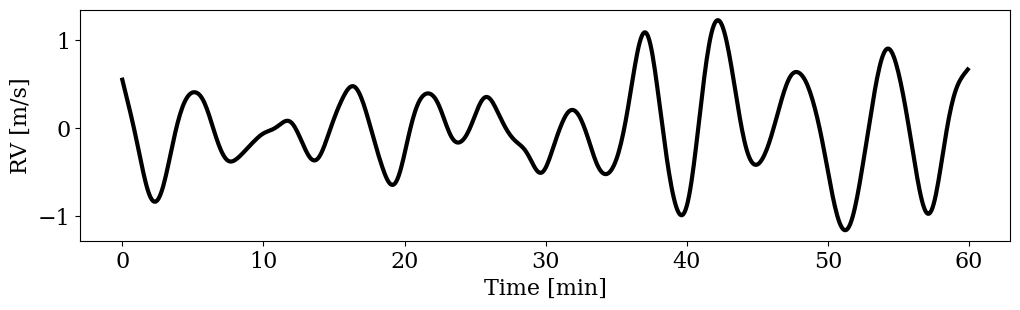

In [9]:
kernel = OscillationKernel()

def get_true_gp(tmax, dt=5/60):
    t = u.Quantity(jnp.arange(0, tmax, dt), 'min')
    true_gp = tinygp.GaussianProcess(kernel, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(69)) 
    f = make_smoothing_spline(t.value, y_sample, lam=10/60)
    return t, f

t, f = get_true_gp(60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [{t.unit}]');

Here we work out the example of the damped driven simple harmonic oscillator (hereon "SHO") because 
1. it is the kernel of interest that requires our exposure-integrated treatment and 
2. it has a familiar SDE that will guide us to the state space form.

The GP kernel for a SHO with parameters $S_0$, $\omega_0$, and $Q$ has the following form ([Foreman-Mackey et al. 2017](https://arxiv.org/abs/1703.09710))
\begin{align*}
k(\Delta) &= \sigma^2 \exp\left(-\frac{\omega_0}{2Q}\Delta\right) 
        \begin{cases}
            1 + \omega_0 \Delta                                              & \text{for } Q = 1/2 \\
            \cos(\eta\omega_0\Delta)  + \frac{1}{2\eta Q}\sin(\eta\omega_0\Delta)  & \text{for } Q > 1/2 \\
            \cosh(\eta\omega_0\Delta) + \frac{1}{2\eta Q}\sinh(\eta\omega_0\Delta) & \text{for } Q < 1/2 
        \end{cases}, \tag{Kernel}
\end{align*}
where we have also used the shorthand variables $\sigma = \sqrt{S_0\omega_0Q}$ and $\eta = \sqrt{|1 - 1/(4Q^2)|}$.

The corresponding power spectral density is
\begin{align*}
S(\omega) = \sqrt{\frac{2}{\pi}} \frac{S_0\,\omega_0^4}
        {(\omega^2-{\omega_0}^2)^2 + {\omega_0}^2\,\omega^2/Q^2}, \tag{PSD}
\end{align*}
which clearly has the desired form of (constant)/(polynomial in $\omega^2$). 

The corresponding SDE for a state $x(t)$ (e.g. displacement) is 
\begin{align*}
\frac{d^2x}{dt^2} + \frac{w_0}{Q} \frac{dx}{dt} + \omega_0^2 x(t) = w(t). \tag{SDE}
\end{align*}
We want to put this into the form of Eq. (3):
\begin{align*}
\frac{d\bm{x}}{dt} = \bm{F}\bm{x}(t) + \bm{L}w(t),
\end{align*}
which we can do by setting $\bm{x}(t) = [x, \dot{x}]^T$ and rearranging the SDE to be in companion form:
\begin{align*}
\ddot{x} =  -\omega_0^2 x(t) -\frac{w_0}{Q} \dot{x} + w(t).
\end{align*}
We can read off the coefficients to build $\bm{F}$ and $\bm{L}$:
\begin{align*}
\boxed{
    \bm{F} = \begin{pmatrix}
                0       &       1 \\
            -\omega_0^2 & -\frac{\omega_0}{Q}
         \end{pmatrix},
         \qquad
\bm{L} = \begin{pmatrix}
            0 \\ 1
          \end{pmatrix}.
          } 
\end{align*} 

To get $Q_c$ and $P_\infty$, we use these $\bm{F}$ and $\bm{L}$ and define a dummy $P_\infty = \begin{pmatrix}P_{11} & P_{12} \\ P_{21} & P_{22} \end{pmatrix}$ and $Q_c = (Q_c)$ and subsitute into the continuous-time Lyapunov equation:
\begin{align*}
\begin{pmatrix} 0 & 1 \\ -\omega_0^2 & -\frac{\omega_0}{Q} \end{pmatrix}
\begin{pmatrix}P_{11} & P_{12} \\ P_{21} & P_{22} \end{pmatrix} + 
\begin{pmatrix}P_{11} & P_{12} \\ P_{21} & P_{22} \end{pmatrix} 
\begin{pmatrix} 0 & -\omega_0^2\\ 1 & -\frac{\omega_0}{Q} \end{pmatrix} + 
\begin{pmatrix} 0 \\ 1 \end{pmatrix} (Q_c) \begin{pmatrix} 0 & 1 \end{pmatrix} = 0. \nonumber
\end{align*}
Working out the multiplications yields four equations which we can solve for each element of $P_\infty$,
\begin{align*}
P_\infty = \begin{pmatrix} \frac{Q Q_c}{2\omega_0^3} & 0 \\ 0 & \frac{QQ_c}{2\omega_0} \end{pmatrix}.
\end{align*}
Then setting the $P_{\infty,11}$ element (stationary variance in the state) equal to $k(0) = \sigma^2$ we have

\begin{align*}
\boxed{
\bm{Q_c} = \frac{2\omega_0^3}{Q}\sigma^2,  \qquad
\bm{P}_\infty = \sigma^2 \begin{pmatrix}
            1 & 0 \\ 
            0 & \omega_0^2
            \end{pmatrix}.
} 
\end{align*} 

### Deriving the transition matrix $A_k$ and process covariance $Q_k$ for the SHO

[Jordán, Eyheramendy, and Buchner (2021)](https://arxiv.org/pdf/2109.10685) worked out $\bm{A}_k$ and $\bm{Q}_k$ for the Matern family and SHO. They derived full analytic expressions for $\exp(\bm{F}\Delta)$ and the Lyapunov integral for $Q_k$ using a Laplace transform, matrix factorization, and a symbolic mathematics package. A perhaps easier way is to use the well-known solution $x(t)$ to the SDE for a given kernel and read off $\bm{A}_k$ from its definition:
\begin{align*}
x(t) = \exp\left(\bm{F}t\right) x(t=0) = \bm{A}_k x(t=0) \; \rightarrow \; \bm{A}_k = x(t) / x(t=0),
\end{align*}
and then determine $\bm{Q}_k$ from the matrix equation involving $\bm{A}_k$ and $\bm{P}_\infty$ noted above (Eq. 1.10).

In any case, the result for the SHO is
<!-- # beta ==  Q eta        from paper above -->
<!-- # f and g == 2 eta Q    from Dan's tinygp implementation -->
$\providecommand{\arg}{}$
$\providecommand{\sinarg}{}$
$\providecommand{\cosarg}{}$
$\providecommand{\sinharg}{}$
$\providecommand{\cosharg}{}$
$\renewcommand{\arg}{\eta\omega_0\Delta_k}$
$\renewcommand{\sinarg}{\sin(\arg)}$
$\renewcommand{\cosarg}{\cos(\arg)}$
$\renewcommand{\sinharg}{\sinh(\arg)}$
$\renewcommand{\cosharg}{\cosh(\arg)}$
\begin{align*}
    \bm{A}_{k} = \Phi(\Delta_k) = 
    \begin{cases}
        \exp\left(-\omega_0\Delta_k\right)
            \begin{pmatrix}
                    1 + \omega_0\Delta_k  & \Delta_k \\
                    -\omega_0^2 \Delta_k  & 1 - \omega_0\Delta_k
            \end{pmatrix} & \text{for } Q = 1/2 \\
            \\
        \exp\left( -\frac{\omega_0\Delta_k}{2Q} \right)
            \begin{pmatrix}
                    \cosarg + \frac{1}{2\eta Q}\sinarg   &   \frac{1}{\eta\omega_0} \sinarg  \\
                    \frac{-\omega_0}{\eta}\sinarg       &   \cosarg - \frac{1}{2\eta Q}\sinarg
            \end{pmatrix} & \text{for } Q > 1/2 \\
            \\
        \exp\left( -\frac{\omega_0\Delta_k}{2Q} \right)
            \begin{pmatrix}
                    \cosharg + \frac{1}{2\eta Q}\sinharg   &   \frac{1}{\omega_0\eta} \sinharg  \\
                    \frac{-\omega_0}{\eta} \sinharg   &   \cosharg - \frac{1}{2\eta Q}\sinharg
            \end{pmatrix} & \text{for } Q < 1/2
    \end{cases}
\end{align*}

Note that the `transition_matrix` defined in `tinygp.kernels.quasisep.SHO` is the transpose of the above. 

The expression given in [Jordán, Eyheramendy, and Buchner (2021)](https://arxiv.org/pdf/2109.10685) for $\bm{Q}_k$ is actually wrong. I think the origin of the problem has something to do with their PSD normalization and therefore their $Q_c$. We derive $\bm{Q}_k$ here by substituting the above $\bm{A}_k$ into the expression $\bm{Q}_k = \bm{P_\infty} - \bm{A_k} \bm{P_\infty} \bm{A}_k^T$. We obtained (for $Q > 1/2$)$\providecommand{\Qaa}{}$
$\providecommand{\Qab}{}$
$\providecommand{\Qba}{}$
$\providecommand{\Qbb}{}$
$\renewcommand{\Qaa}{e^{\frac{\omega_0\Delta_k}{Q}} - 1 - \frac{1}{2\eta Q}\sin(2\arg) + (1 - \frac{1+4Q^2}{4\eta^2Q^2}) \sin^2(\arg)
}$
$\renewcommand{\Qab}{\frac{\omega_0}{\eta^2Q}\sin^2(\arg)}$
$\renewcommand{\Qba}{\Qab}$
$\renewcommand{\Qbb}{\omega^2 \left[ \exp(\frac{\omega_0\Delta_k}{Q}) - 1 + \frac{1}{2\eta Q}\sin(2\arg) + (1 - \frac{1+4Q^2}{4\eta^2Q^2}) \sin^2(\arg)  \right]}$
\begin{align*}
    \bm{Q}_{k} = \sigma^2 \exp\left( -\frac{\omega_0\Delta_k}{Q} \right)
            \begin{pmatrix}
                    \Qaa  &  \Qab  \\
                    \; \\
                    \Qba  &  \Qbb
            \end{pmatrix}.
\end{align*}


In [15]:
class SHO(StateSpaceModel):
    r"""The damped, driven simple harmonic oscillator kernel

    Args:
        omega: The parameter :math:`\omega_0`.
        quality: The parameter :math:`Q`.
        sigma: The parameter :math:`\sigma`.
    """

    omega:   JAXArray | float
    quality: JAXArray | float
    sigma:   JAXArray | float = eqx.field(default_factory=lambda: jnp.ones(()))
    eta:     JAXArray | float
    d:       JAXArray | float = eqx.field(static=True)

    def __init__(self, omega: JAXArray | float, quality: JAXArray | float, sigma: JAXArray | float = 1.0):  
        self.omega = omega
        self.quality = quality
        self.sigma = sigma

        self.eta = jnp.sqrt(jnp.abs(1-1/(4*self.quality**2)))

        self.d = 2 # dimension of the state vector (order of the SDE)

    def noise(self) -> JAXArray:
        ''' The scalar Qc '''
        omega3 = jnp.power(self.omega,3)
        return jnp.array([[2*omega3*jnp.square(self.sigma)/self.quality]])
    
    def design_matrix(self) -> JAXArray:
        ''' The matrix F (also called the feedback matrix)'''
        return jnp.array(
            [[0, 1], [-jnp.square(self.omega), -self.omega / self.quality]]
        )

    def noise_effect(self) -> JAXArray:
        ''' The matrix L '''
        return jnp.array([[0], [1]])

    def stationary_covariance(self) -> JAXArray:
        ''' The matrix Pinf '''
        return jnp.diag(jnp.square(self.sigma) * jnp.array([1, jnp.square(self.omega)]))

    def observation_model(self, X: JAXArray) -> JAXArray:
        ''' The matrix H '''
        del X
        return jnp.array([[1, 0]])

    def transition_matrix(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
        ''' The matrix A_k '''
        dt = X2 - X1
        n = self.eta
        w = self.omega
        q = self.quality

        def critical(dt: JAXArray) -> JAXArray:
            return jnp.exp(-w * dt) * jnp.array(
                [[1 + w * dt, dt], [-jnp.square(w) * dt, 1 - w * dt]]
            )

        def underdamped(dt: JAXArray) -> JAXArray:
            f = 2*n*q
            x = n*w*dt
            sin = jnp.sin(x)
            cos = jnp.cos(x)
            return jnp.exp(-0.5*w*dt/q) * jnp.array(
                [
                    [cos+sin/f, sin/(w*n)],
                    [-w*sin/n , cos-sin/f]
                ]
            )

        def overdamped(dt: JAXArray) -> JAXArray:
            f = 2*n*q
            x = n*w*dt
            sinh = jnp.sinh(x)
            cosh = jnp.cosh(x)
            return jnp.exp(-0.5*w*dt/q) * jnp.array(
                [
                    [cosh+sinh/f, sinh/(w*n)],
                    [-w*sinh/n  , cosh-sinh/f]
                ]
            )
        
        return jax.lax.cond(
            jnp.allclose(q, 0.5),
            critical,
            lambda dt: jax.lax.cond(q > 0.5, underdamped, overdamped, dt),
            dt,
        )

    
    def process_noise(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
        ''' The matrix Q_k '''
        dt = X2 - X1
        n = self.eta
        w = self.omega
        q = self.quality
        assert q>0.5 # TODO: currently only for Q>1/2

        def critical(dt: JAXArray) -> JAXArray:
            return jnp.array([[0.,0.],[0.,0.]])

        def underdamped(dt: JAXArray) -> JAXArray:
            f = 2*n*q; f2 = jnp.square(f); n2 = jnp.square(n); w2 = jnp.square(w)
            a = w*dt/q # argument in exponential
            x = n*w*dt # argument in sin/cos
            exp = jnp.exp(a)
            sin = jnp.sin(x)
            sin2 = jnp.sin(2*x)
            sinsq = jnp.square(sin)
            Q11 = exp - 1 - sin2/f + (1 - (n2+f2)/(n2*f2)) * sinsq
            Q12 = Q21 = w*sinsq/(n2*q)
            Q22 = w2 * (exp - 1 + sin2/f + (1 - (n2+f2)/(n2*f2)) * sinsq )
            return jnp.square(self.sigma) * jnp.exp(-a) * jnp.array(
                [
                    [Q11, Q12],
                    [Q21, Q22]
                ]
            ) 

        def overdamped(dt: JAXArray) -> JAXArray:
            return jnp.array([[0.,0.],[0.,0.]])
    
        return jax.lax.cond(
            jnp.allclose(q, 0.5),
            critical,
            lambda dt: jax.lax.cond(q > 0.5, underdamped, overdamped, dt),
            dt,
        )
    
    def integrated_transition_matrix(self, t1: JAXArray, t2: JAXArray) -> JAXArray:
        ''' Integrated transition matrix from t1 to t2 '''
        n = self.eta
        w = self.omega
        q = self.quality

        a = -0.5*w/q
        b = n*w
        a2plusb2 = jnp.square(a) + jnp.square(b)
        A = 1/(2*n*q)
        B = 1/(n*w) # = 1/b
        C = -w/n

        def critical(t1: JAXArray, t2: JAXArray) -> JAXArray:
            return jnp.array([[0.,0.],[0.,0.]])

        def underdamped(t1: JAXArray, t2: JAXArray) -> JAXArray:
     
            def Int_ecos(t):
                return jnp.exp(a*t) * (a*jnp.cos(b*t) + b*jnp.sin(b*t))

            def Int_esin(t):
                return jnp.exp(a*t) * (a*jnp.sin(b*t) - b*jnp.cos(b*t))
            
            Ic = Int_ecos(t2) - Int_ecos(t1)
            Is = Int_esin(t2) - Int_esin(t1)
            Phibar11 = Ic + A*Is
            Phibar12 = B * Is
            Phibar21 = C * Is
            Phibar22 = Ic - A*Is
 
            return jnp.array([
                            [Phibar11, Phibar12],
                            [Phibar21, Phibar22]
                        ]) / a2plusb2

        def overdamped(t1: JAXArray, t2: JAXArray) -> JAXArray:
            return jnp.array([[0.,0.],[0.,0.]])
        
        return jax.lax.cond(
            jnp.allclose(q, 0.5),
            critical,
            lambda t1,t2: jax.lax.cond(q > 0.5, underdamped, overdamped, t1,t2),
            t1,t2,
        )

### Define SHO for oscillations and build the model

In [16]:
def build_sho_model(omega=kernel.w, quality=kernel.Q, sigma=kernel.sig):

    sho = SHO(omega=omega, quality=quality, sigma=sigma)
    
    F = sho.design_matrix()
    L = sho.noise_effect()
    H = sho.observation_model(None)
    A = sho.transition_matrix
    Q = sho.process_noise
    Qc = sho.noise()
    Pinf = sho.stationary_covariance()
    Phibar = lambda dt: sho.integrated_transition_matrix(0, dt)
    
    return F, L, Qc, Pinf, H, A, Q, Phibar

In [17]:
F, L, Qc, Pinf, H, A, Q, Phibar = build_sho_model()

### Verify we integrated $\Phi$ correctly

In [18]:
Phi = lambda tau : A(0,tau) # expm(F * tau) 

def Phibar_numerical(dt, M=100000):
    taus = jnp.linspace(0, dt, M)
    integrand = jax.vmap(Phi)(taus)
    return jnp.trapezoid(integrand, taus, axis=0)

In [19]:
texp_test = 120

print('Analytic')
print(Phibar(texp_test))
print()
print('Numerical')
print(Phibar_numerical(texp_test))

Analytic
[[ 4.22655428e+01  4.08389241e+03]
 [-1.55290009e+00  3.18283341e+01]]

Numerical
[[ 4.22655428e+01  4.08389241e+03]
 [-1.55290009e+00  3.18283341e+01]]


In [20]:
texp_tests = jnp.logspace(-1, 3, 1000)

analytic  = jax.vmap(Phibar)(texp_tests)
numerical = jax.vmap(Phibar_numerical)(texp_tests)
jnp.allclose(analytic, numerical)

Array(True, dtype=bool)

### Verify $A$ and $Q$ are correct

In [21]:
# The transition matrix is the matrix exponential of F*dt
# Can verify we did the math right by comparing to numerical matrix exponential
A_calc = lambda dt: expm(F*dt)
A_full = lambda dt: A(0,dt)
dts = jnp.linspace(-1000,1000,100000)

jnp.allclose(jax.vmap(A_calc)(dts), jax.vmap(A_full)(dts))

Array(True, dtype=bool)

In [22]:
@jax.jit
def Q_from_int(dt):
    '''
    Calculates Q = ∫0^dt exp(F (dt-τ)) L Qc L^T exp(F^T (dt-τ)) dτ
    using numerical integration via trapezoidal rule (simple, for testing)

    See Eq. 11 in Solin & Sarkka (2014) == https://proceedings.mlr.press/v33/solin14.pdf
    '''
    n_steps = 10000
    taus = jnp.linspace(0, dt, n_steps)
    integrand = jax.vmap(lambda tau: expm(F * (dt-tau)) @ L @ Qc @ L.T @ expm(F * (dt-tau)).T)(taus)
    Q = jnp.trapezoid(integrand, taus, axis=0)
    return Q
    
def Q_from_Pinf(dt):
    # Better version from Solin and Sarkka 2014 (from a paper cited therein)
    A_k = A(0,dt)
    return Pinf - A_k @ Pinf @ A_k.T 

In [23]:
dt = jnp.linspace(-1000,1000,500)

# "proof" that Pinf - A Pinf A^T is the same as the lyapunov integral
jnp.allclose(jax.vmap(Q_from_Pinf)(dt), jax.vmap(Q_from_int)(dt))

Array(True, dtype=bool)

In [24]:
# Now verify we did the math correctly
Q_full = lambda dt: Q(0,dt)
dts = jnp.linspace(-1000,1000,100000)
jnp.allclose(jax.vmap(Q_from_Pinf)(dts), jax.vmap(Q_full)(dts))

Array(True, dtype=bool)

In [25]:
dt = 1e6
# numerical method breaks down completely
# around dt=1e6 in this example (underflow?)
A_calc(dt)

Array([[nan, nan],
       [nan, nan]], dtype=float64)

In [26]:
## Comparison to Van-Loan trick
dts = jnp.linspace(0,1000,100)
jnp.all(jax.vmap(lambda dt: jnp.allclose(Q(0,dt), Q_from_VanLoan(F, L, Qc, dt)))(dts))

Array(True, dtype=bool)

# 2. Kalman filter

The Kalman filter ([Kalman 1960](https://www.unitedthc.com/DSP/Kalman1960.pdf)) is an iterative algorithm that steps through the data array, predicting the state at the current iteration based on the previous. The iteration starts at the prior mean $m_0$ (in many GP cases we have zero-mean) and prior covariance $P_0 = P_\infty$. 

The algorithm is [(Theorem 6.6 in S&auml;rkk&auml; and Svensson 2023)](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf):

\begin{align*}

\text{Prediction:}&  \\

m_{k}^{-} &= A_{k-1} m_{k-1},  \\

P_{k}^{-} &= A_{k-1} P_{k-1} A_{k-1}^T + Q_{k-1}.  \\

\text{Update:}&    \\

v_k &= y_k - H_k m_k^{-},  \\

S_k &= H_k P_k^{-} H_k^T + R_k,  \\

K_k &= P_k^{-} H_k^T S_k^{-1},  \\

m_k &= m_k^{-} + K_k v_k,  \\

P_k &= P_k^{-} - K_k S_k K_k^T.  \\

\end{align*}

The prediction step can be thought of as simply transitioning from the previous (filtered) state to the current timestep.

The update step first calculates the "surprise term" $v_k$ (also called the innovation), which is simply the difference between our prediction (when projected into the observed space via the observation model $H$) and the actual measured value. The uncertainty in the prediction ($S_k$), also called the innovation covariance,  defines the Kalman Gain ($K_k$), which tells us how much to trust the measurement/acts as weighting to the surprise term for the purpose of updating our predicted mean $m_k$ and variance $P_k$.

In [27]:
@jax.jit
def kalman_filter(H, R, t, y, m0, P0):
    '''
    Jax implementation of the Kalman filter algorithm

    See Theorem 4.2 (pdf page 77) in "Bayesian Filtering and Smoothing" 
    by Simo S{\"a}rkk{\"a} for detailed description of the algorithm and notation.

    e.g. _prev is _{k-1} in Sarkka notation
         _pred is _k^{-} in Sarkka notation

    Total runtime complexity is O(N*d^3) where N is the number 
    of time steps and d is the dimension of the state vector.
    '''
    N = len(t) # number of data points

    if len(H) != N:
        H = jnp.full((N, *H.shape), H)  # case of constant observation model

    def step(carry, k):
        '''
        Routine for a single step of the Kalman filter

        Parameters:
            carry: (x_prev, P_prev) - previous state and covariance
            k: index of the current time step
        
        Returns:
        - Conditioned state (m_k) and covariance (P_k) to carry to next iteration
        - Full output for completed scan (m_k, P_k, m_pred, P_pred)
        '''

        # Unpack previous state and covariance
        m_prev, P_prev = carry

        # Logic to check if first time step:
        # If k==0 we use the prior x0, P0
        # and zero time-lag (Delta=0)
        Delta = jax.lax.cond(k > 0,
                             lambda i: t[i] - t[i-1],
                             lambda _: 0.0,
                             k)
        
        # Get transition matrix
        A_prev = A(0,Delta)
        Q_prev = Q(0,Delta)
        
        # Predict (Eq. 4.20)
        m_pred = A_prev @ m_prev
        P_pred = A_prev @ P_prev @ A_prev.T + Q_prev 
        
        # Update (Eq. 4.21)
        H_k = H[k] # observation model for this time step
        y_pred = H_k @ m_pred             # predicted observation
        v_k = y[k] - y_pred               # "innovation" or "surprise" term
        S_k = H_k @ P_pred @ H_k.T + R[k] # uncertainy in predicted observation
        # S_k_inv = jnp.linalg.inv(S_k)
        # K_k = P_pred @ H_k.T @ S_k_inv    # Kalman gain
        K_k = jnp.linalg.solve(S_k.T, (P_pred @ H_k.T).T).T # more stable
        m_k = m_pred + K_k @ v_k          # conditioned state estimate
        P_k = P_pred - K_k @ S_k @ K_k.T  # conditioned covariance estimate
        
        return (m_k, P_k), (m_k, P_k, m_pred, P_pred)
    
    # Initialize carry with prior state and covariance
    init_carry = (m0, P0)

    # Run the filter over all time steps, unpack, and return results
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(N))
    m_filtered, P_filtered, m_predicted, P_predicted = outputs
    return m_filtered, P_filtered, m_predicted, P_predicted


# 3. Rauch–Tung–Striebel (RTS) smoother

The Rauch-Tung Striebel (RTS) smoothing algorithm ([Rauch, Tung, Striebel 1965](https://arc.aiaa.org/doi/abs/10.2514/3.3166)) applies the transition matrix to the Kalman filtered mean and covariance estimates to update those predictions in reverse-chronological order. Note this is not the same as applying Kalman filtering in reverse as there are causality assumptions built into the noise model that need to be treated carefully. In other words, conditioning a GP on two halves of a dataset and stitching them together violates the joint covariance structure. While the Kalman filter walks the state forward in time according to the noise model, the RTS smoother _corrects_ those forward predictions (Bayesian refinement) using information about the future.

The final result of Kalman filtering followed by RTS smoothing is the optimal predictive distribution that incorporates all available data. This is mathematically equivalent to full GP conditioning when the state space SDE is linear and the driving noise is Gaussian (See [S&auml;rkk&auml; and Hartikainen 2012](https://proceedings.mlr.press/v22/sarkka12/sarkka12.pdf) and [Ch. 12.4 of S&auml;rkk&auml; and Solin 2019](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf), and references therein in). I.e. $\hat{m} \equiv \mu_{GP}$ and $\hat{P} \equiv \text{Cov}_{GP}$.

The RTS algorithm is [(Theorem 12.2 in S&auml;rkk&auml; and Svensson 2023)](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf):

\begin{align*}

m_{k+1}^{-} &= A_k m_k, \nonumber \\

P_{k+1}^{-} &= A_k P_k A_k^T + Q_k, \nonumber \\

G_k &= P_k A_k^T \left[ P_{k+1}^{-} \right]^{-1}, \nonumber \\

\hat{m}_k &= m_k + G_k \left[ \hat{m}_{k+1} - m_{k+1}^{-} \right], \nonumber \\

\hat{P}_k &= P_k + G_k \left[ \hat{P}_{k+1} - P_{k+1}^{-} \right] G_k^T.  

\end{align*}

Where $m_k$ and $P_k$ are the outputs of the Kalman filter (see above). Note that the first two steps ($m_{k+1}^{-}$ and $P_{k+1}^{-}$) are also determined during the Kalman algorithm (i.e. they are the predicted mean and covariance in latent space). $G_k$ is the "smoothing gain."

In [28]:
@jax.jit
def rts_smoother(t, m_filtered, P_filtered, m_predicted, P_predicted):
    '''
    Jax implementation of the Rauch-Tung-Striebel (RTS) smoothing algorithm

    See Theorem 8.2 (pdf page 156) in "Bayesian Filtering and Smoothing" 
    by Simo S{\"a}rkk{\"a} for detailed description of the algorithm and notation.
    '''
    N = len(t) # number of data points

    def step(carry, k):
        '''
        Routine for a single step of the RTS smoother

        Parameters:
            carry: (m_next, P_next) - next state and covariance
            k: index of the current time step

            Recall we are iterating backwards, so _next is k+1

        Returns:
        - Smoothed state (m_k_hat) and covariance (P_k_hat) to carry to next iteration
        - Full output for completed scan (m_k_hat, P_k_hat)
        '''

        # Outputs from Kalman filter, unpacked for notational consistency
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        m_pred_next = m_predicted[k+1] # has superscript minus
        P_pred_next = P_predicted[k+1] # has superscript minus

        # Unpack state and covariance from last iteration
        m_hat_next, P_hat_next = carry

        # Time-lag between states
        Delta_k = t[k+1] - t[k]

        # Transition matrix
        A_k = A(0,Delta_k)

        # Compute smoothing gain
        # P_pred_next_inv = jnp.linalg.inv(P_pred_next)
        # G_k = P_k @ A_k.T @ P_pred_next_inv # smoothing gain
        G_k = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T # more stable
        
        # Update state and covariance
        m_hat_k = m_k + G_k @ (m_hat_next - m_pred_next)
        P_hat_k = P_k + G_k @ (P_hat_next - P_pred_next) @ G_k.T
        
        return (m_hat_k, P_hat_k), (m_hat_k, P_hat_k)

    # Start smoothing from final filtered state
    init_carry = (m_filtered[-1], P_filtered[-1])

    # Run backward from N-2 down to 0
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(N-2, -1, -1))
    m_smooth_reversed, P_smooth_reversed = outputs

    # Reverse outputs to match time order
    m_smooth = jnp.vstack([m_smooth_reversed[::-1], m_filtered[-1][None, :]])
    P_smooth = jnp.vstack([P_smooth_reversed[::-1], P_filtered[-1][None, :, :]])
    return m_smooth, P_smooth

# 4. The log-likelihood

Another byproduct of the above algorithms are the ingredients to compute the log-likelihood (Eq. 16.5 in [S&auml;rkk&auml; and Svensson 2023](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf))

\begin{align}
p(y_{1:N} | \theta) = \prod_{k=1}^{N} p(y_k|y_{1:k-1},\theta)  \tag{4.1}
\end{align}

where the individual $p(y_k|y_{1:k-1},\theta)$ are given by the first two pieces of the "update" step in the Kalman filter

\begin{align}
p(y_k|y_{1:k-1},\theta) = N(H_k m_k^{-}, S_k)  \tag{4.2}
\end{align}

thus giving

\begin{align}
\log p(y_{1:N}|\theta) = -\frac{1}{2}\sum_{k=1}^N \left( \log\det(2\pi S_k) + v_k^T S_k^{-1} v_k \right) \tag{4.3}
\end{align}

which can be input to any of the usual methods for hyperparameter optimization.

In [29]:
### TODO: add this to the Kalman filter iteration:
# L_k = jnp.linalg.cholesky(S_k)
# w = solve_triangular(L_k, v_k, lower=True)
# quad = jnp.dot(w, w)
# logdetS_k = 2.0 * jnp.sum(jnp.log(jnp.diag(L_k)))
# m = v_k.shape[0] # dimension of state vector
# loglik -= 0.5 * (quad + logdetS_k + m*jnp.log(2*jnp.pi))

# 5. Predicting at arbitrary times ($X_\text{test}$)

It is straightforward to extend the Kalman/RTS algorithms to predict the mean and covariance at an arbitrary time $t_\ast$. It is related to the idea of "fast sampling" described in Section 4.6 of [S&auml;rkk&auml; and Svensson 2023](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf). There are three cases:

- Retrodiction ($t_\ast < t_1$): If the test point is before the first data point, we backwards-predict using the RTS method from the first measurement's smoothed state, taking the predicted mean at the test point to be zero and the covariance to be the stationary covariance.

- Interpolation ($t_1 < t_\ast < t_N$): If the test point is during the data, we use the usual Kalman prediction step from the most recent data point's Kalman-filtered state, and then refine the prediction with a RTS smoothing step from the nearest future data point's smoothed state.

- Extrapolation ($t_\ast > t_N$): If the test point is after the data, we simply use the Kalman prediction from the final datapoint.

If the various quantities (except for $\bm{A}$ and $\bm{Q}$ which depend on $\Delta$) are saved from the Kalman/RTS steps, they can be reused here for some speedup.

An alternative algorithm was described in [Kelly et al. 2014](https://iopscience.iop.org/article/10.1088/0004-637X/788/1/33/pdf) which uses a linearized form for the predicted state at the test point. This framework is equivalent to the Kalman + RTS interpolation described above, but is more computationally taxing as it requires effectively re-comping the smoothing gain at every test point, which involves a loop through all the future data to that test point.

In [30]:
@jax.jit
def predict_at_times(Pinf, H,
                     m_smooth, P_smooth, 
                     m_filtered, P_filtered,
                     m_predicted, P_predicted,
                     t_obs, t_test, Htest=None):    
        
        
    N = len(t_obs)
    Ntest = len(t_test)

    if Htest is None:
        # TODO: if this needs to be different for test
        # points it needs to be user specified somehow
        Htest = jnp.full((Ntest, *H.shape), H)

    if len(H) != N:        
        # case of constant observation model
        H = jnp.full((N, *H.shape), H)

    # Nearest (future) datapoint
    k_nexts = jnp.searchsorted(t_obs, t_test, side='right')

    # Method to use for test point
    past   = (k_nexts<=0)    # Retrodiction
    future = (k_nexts>=N)    # Forecast
    during = ~past & ~future # Interpolate
    cases = (past.astype(int)*0 + during.astype(int)*1 + future.astype(int)*2)

    def predict(k, ktest):
        '''
        Kalman prediction from most recent 
        filtered (not smoothed) state
        '''
        dt = t_test[ktest] - t_obs[k]
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        A_star = A(0,dt) # transition matrix from t_k to t_star
        Q_star = Q(0,dt) # process noise from t_k to t_star
        m_star_pred = A_star @ m_k
        P_star_pred = A_star @ P_k @ A_star.T + Q_star
        # No Kalman update since we have no data at t_star, so we're done
        return m_star_pred, P_star_pred
    
    def smooth(k_next, ktest, m_star_pred, P_star_pred):
        '''
        RTS smooth the prediction (ktest) using 
        the nearest future (smoothed) state (k_next)

        m_star_pred and P_star_pred are the output of predict(k, k_star)
        '''
        # Next (future) data point predicted & smoothed state
        m_pred_next = m_predicted[k_next] # prediction (no kalman update) at next data point
        P_pred_next = P_predicted[k_next] # prediction (no kalman update) at next data point
        m_hat_next = m_smooth[k_next]     # RTS smoothed state at next data point
        P_hat_next = P_smooth[k_next]     # RTS smoothed covariance at next data point

        # Time-lag between states
        dt = t_obs[k_next] - t_test[ktest]

        # Transition matrix for this step
        A_k = A(0,dt) 

        # Compute smoothing gain
        # P_pred_next_inv = jnp.linalg.inv(P_pred_next)
        # G_k = P_star_pred @ A_k.T @ P_pred_next_inv # smoothing gain
        G_k = jnp.linalg.solve(P_pred_next.T, (P_star_pred @ A_k.T).T).T # more stable
        
        # Update state and covariance
        m_star_hat = m_star_pred + G_k @ (m_hat_next - m_pred_next)
        P_star_hat = P_star_pred + G_k @ (P_hat_next - P_pred_next) @ G_k.T
        
        return m_star_hat, P_star_hat

    def project(ktest, m_star, P_star):
        ''' Project the state vector to the observation space '''
        Hk = Htest[ktest]
        pred_mean = (Hk @ m_star.T).squeeze()
        pred_var  = (Hk @ P_star @ Hk.T).squeeze()
        return pred_mean, pred_var

    def retrodict(ktest):
        ''' Reverse-extrapolate from first datapoint t_star '''
        m_star, P_star = smooth(0, ktest, 0, Pinf)
        return project(ktest, m_star, P_star)

    def interpolate(ktest):
        ''' Interpolate between nearest data points '''
        
        # Get nearest data point before and after the test point
        k_next = k_nexts[ktest]
        k_prev = k_next - 1

        # 1. Kalman predict from most recent data point (in past)
        m_star_pred, P_star_pred = predict(k_prev, ktest)

        # 2. RTS smooth from next nearest data point (in future)
        m_star_hat, P_star_hat = smooth(k_next, ktest, m_star_pred, P_star_pred)

        return project(ktest, m_star_hat, P_star_hat)

    def extrapolate(ktest):
        ''' Kalman predict from from last datapoint t_star '''
        m_star, P_star = predict(-1, ktest)
        return project(ktest, m_star, P_star)
    
    # Calculate predictions
    ktests = jnp.arange(0, Ntest, 1)
    branches = (retrodict, interpolate, extrapolate)
    (pred_mean, pred_var) = jax.vmap(lambda ktest: jax.lax.switch(cases[ktest], branches, (ktest)))(ktests)

    return pred_mean, pred_var

#### GP version

Full dense matrix calculation for predictive mean and variance

In [31]:
## From early testing: GP matrix equations for predictive mean/var
def matern32_kernel(t1, t2, scale=1.0, sigma=1.0):
    dt = jnp.abs(t1[:, None] - t2[None, :])
    sqrt3 = jnp.sqrt(3.0)
    f = sqrt3 / scale
    return sigma**2 * (1 + f*dt) * jnp.exp(-f * dt)

def gp_posterior(t_train, y_train, t_test, noise_var):
    K = matern32_kernel(t_train, t_train) + jnp.eye(len(t_train)) * noise_var
    K_s = matern32_kernel(t_test, t_train)
    K_ss = matern32_kernel(t_test, t_test)

    K_inv = jnp.linalg.inv(K)
    mu = K_s @ K_inv @ y_train
    cov = K_ss - K_s @ K_inv @ K_s.T
    return mu, cov

## 5.1. Compare Kalman/RTS to full GP

### Simulated data

In [32]:
#### Simulated dataset
N = 30
yerr = 0.3 # m/s

np.random.seed(231)
times = jnp.sort(np.random.uniform(t.value.min(), t.value.max(), N))  # Randomly sample N points
tobs = u.Quantity(times, t.unit)

y_true = f(tobs.value)

t_train = tobs.to(kernel.tunit).value # times in unit of the kernel (for computing Delta) 
y_train = y_true + yerr * jax.random.normal(key, shape=(N,))

R = jnp.full(N, yerr**2)

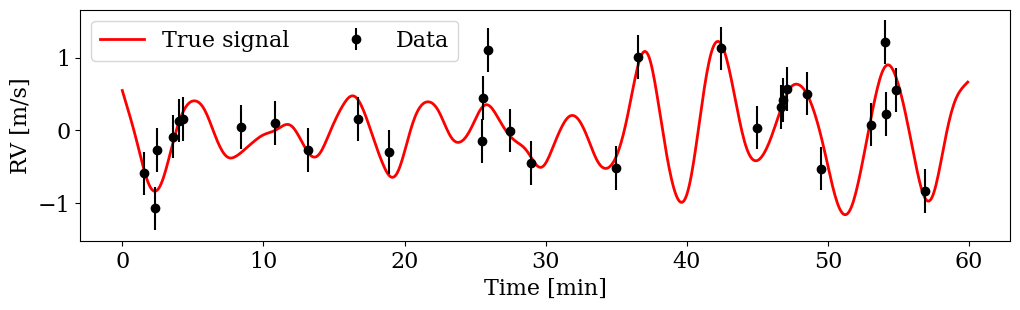

In [33]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(tobs.value, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [{t.unit}]');

## Kalman/RTS prediction

In [34]:
## Setup state space model
F, L, Qc, Pinf, H, A, Q, Phibar = build_sho_model()

# Initial latent state prior
d = len(F)
m0 = jnp.zeros(d)       # prior mean at t=0 (i.e. "the GP mean function")
P0 = Pinf               # prior covariance at t=0 (i.e. stationary covariance)

In [35]:
# Kalman filters
m_filtered, P_filtered, m_predicted, P_predicted = kalman_filter(H, R, t_train, y_train, m0, P0)

# RTS smoother
m_smooth, P_smooth = rts_smoother(t_train, m_filtered, P_filtered, m_predicted, P_predicted)

# Project predictive mean/var to observation space
y_kal = (H @ m_filtered.T).squeeze()
yvar_kal = (H @ P_filtered @ H.T).squeeze()
yerr_kal = jnp.sqrt(yvar_kal)

y_rts = (H @ m_smooth.T).squeeze()
yvar_rts  = (H @ P_smooth @ H.T).squeeze()
yerr_rts = jnp.sqrt(yvar_rts)

In [36]:
# Time grid for making the prediction
t_sec = t.to(kernel.tunit).value
t_test = jnp.linspace(t_sec.min(), t_sec.max(), 1000)

In [37]:
# Predict at test times
mu_ss, var_ss = predict_at_times(Pinf, H, 
                                 m_smooth, P_smooth, 
                                 m_filtered, P_filtered,
                                 m_predicted, P_predicted,
                                 t_train, t_test, Htest=None)
std_ss = jnp.sqrt(var_ss)

### Full GP prediction

In [38]:
diag = yerr**2 

#### unit-aware custom SHO
# gp = tinygp.GaussianProcess(kernel, tobs, diag=diag)
# y_gp, yvar_gp = gp.predict(y_train, tobs, kernel=kernel, return_var=True)
# mu_gp, var_gp = gp.predict(y_train, tobs_test, kernel=kernel, return_var=True)

#### tinygp quasiseparable SHO
shokern = tinygp.kernels.quasisep.SHO(omega=kernel.w, quality=kernel.Q, sigma=kernel.sig)
gp = tinygp.GaussianProcess(shokern, t_train, diag=diag)
y_gp, yvar_gp = gp.predict(y_train, t_train, kernel=shokern, return_var=True)
mu_gp, var_gp = gp.predict(y_train, t_test,  kernel=shokern, return_var=True)

In [39]:
yerr_gp = jnp.sqrt(yvar_gp)
std_gp  = jnp.sqrt(var_gp)

### Plot

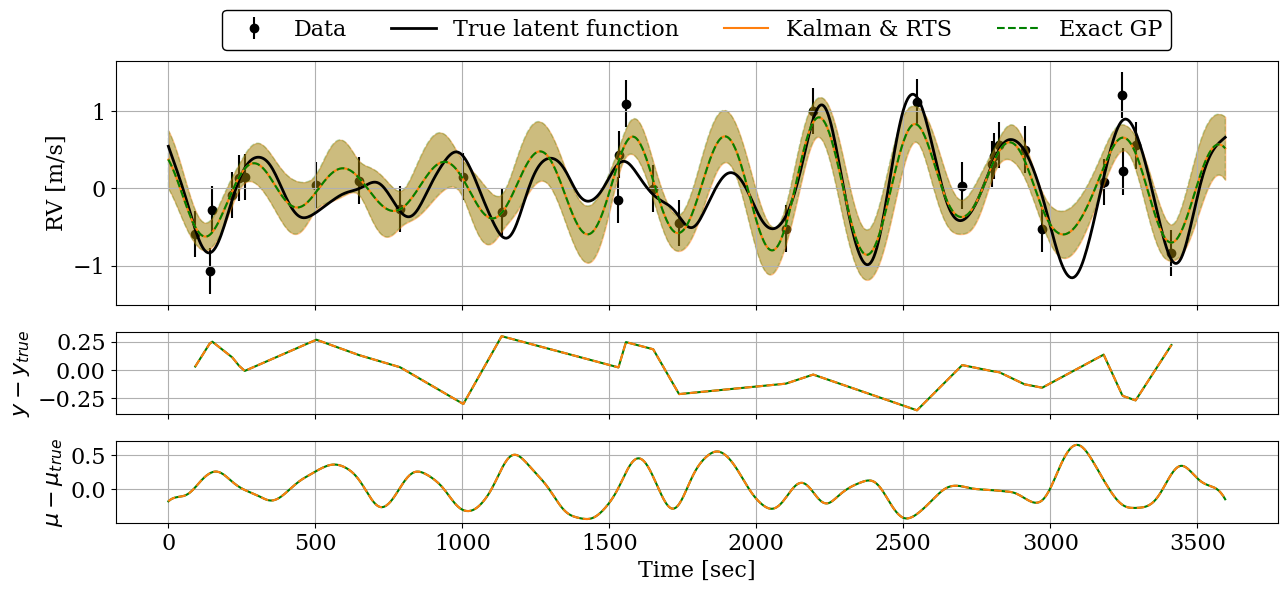

In [40]:
fig, (ax, rax1, rax2) = plt.subplots(3,1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

cobs = 'k' # 'w'
ctrue = 'k'
cgp  = 'g'
ckal = 'C0'
crts = 'C1'

## Data and true signal
l1 = ax.errorbar(t_train, y_train, yerr, fmt='o', zorder=0, color=cobs, label="Data")
l2, = ax.plot(t.to(kernel.tunit).value, f(t), color=ctrue, lw=2, label="True latent function")

## Kalman filtered result
# l3, = ax.plot(t_train, y_kal, 'o', color=ckal,  ls=':',  label="Kalman Filtered Mean")
# ax.fill_between(t_train, y_kal-yerr_kal, y_kal+yerr_kal, color=ckal, alpha=0.2)

# ## RTS smoothed result
# l4, = ax.plot(t_train, y_rts, 'o', color=crts,  ls='-', label="RTS Smoothed Mean")
# ax.fill_between(t_train, y_rts-yerr_rts, y_rts+yerr_rts, color=crts, alpha=0.2)

# ## GP solution
# l5, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='-',  label="Exact GP Mean")
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)

## Test predictions
l4, = ax.plot(t_test, mu_ss, color=crts,  ls='-', label="Kalman & RTS")
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, ls='-', color=crts, alpha=0.4)

l5, = ax.plot(t_test, mu_gp,  color=cgp,   ls='--',  label="Exact GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, ls='--', color=cgp, alpha=0.2)

lines = [l1, l2, l4, l5]
ax.legend(lines, [l.get_label() for l in lines],
            ncol=4,# loc='upper center', #fontsize=14,
            loc='lower center', bbox_to_anchor=[0.5,1],
              framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
# ax.set_title("State-Space GP vs. Exact GP")
ax.set(ylabel='RV [m/s]', )#xlim=[max(t_test.min(), t.min().to(kernel.tunit).value),
                        #  min(t_test.max(), t.max().to(kernel.tunit).value)])
# ax.set_ylim(f(t).min()-.2, f(t).max()+1)
ax.grid()

# rax.plot(t_train, y_kal-y_true, ckal, ls=':')
rax1.plot(t_train, y_gp-y_true,  cgp , ls='-')
rax1.plot(t_train, y_rts-y_true, crts, ls='--')

mu_true = f(t_test/60)
rax2.plot(t_test, mu_gp-mu_true, c=cgp , ls='-')
rax2.plot(t_test, mu_ss-mu_true, c=crts, ls='--')
# rax2.fill_between(t_test, mu_gp-std_gp - mu_true, mu_gp+std_gp - mu_true, ls='--', color=cgp, alpha=0.2)
# rax2.fill_between(t_test, mu_ss-std_ss - mu_true, mu_ss+std_ss - mu_true, ls='-', color=crts, alpha=0.2)

rax1.set(ylabel=r'$y-y_{true}$')
rax2.set(xlabel='Time [sec]', ylabel=r'$\mu-\mu_{true}$')

rax1.grid();rax2.grid();

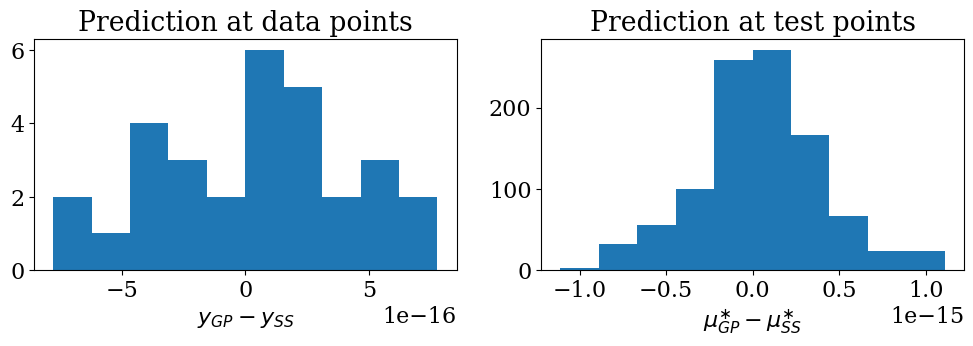

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_rts);
# plt.hist(mu_gp - mu_rts);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_gp - mu_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# 6. Timed benchmark comparison

In [42]:
import time

In [43]:
t.shape

(720,)

In [44]:
def get_stuff(N):

    if N<200:
        times = jnp.sort(np.random.uniform(t.value.min(), t.value.max(), N))
        y_true = f(times)
    else:
        # Split into 200 points per day
        times = jnp.linspace(t.value.min(), t.value.max(), 200)
        y_true = jnp.tile(f(times), N//200 + 1)[:N]
        times  = jnp.hstack([day*1440 + times for day in range(N//200+1)])[:N]

    tobs = u.Quantity(times, t.unit)
    t_train = tobs.to(kernel.tunit).value # times in unit of the kernel (for computing Delta) 
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))

    # Time grid for making the prediction
    t_test = t_train
    # t_test = jnp.linspace(0, t.value.max(), 1000)

    return tobs, t_train, y_train, t_test

In [45]:
recompute = False
# recompute = True

In [46]:
if recompute:
    tss = []
    tgp = []
    tqs = []

    Ns = np.logspace(1, 6, 11).astype(int)

    for N in Ns:

        tobs, t_train, y_train, t_test = get_stuff(N)

        # Kalman filters/RTS smooth/projection
        tstart = time.time()
        m_filtered, P_filtered, m_predicted, P_predicted = kalman_filter(H, R, t_train, y_train, m0, P0)
        m_smooth, P_smooth = rts_smoother(t_train, m_filtered, P_filtered, m_predicted, P_predicted)
        # filt_mean   = (H @ m_filtered.T).squeeze()
        # filt_var    = (H @ P_filtered @ H.T).squeeze()
        # smooth_mean = (H @ m_smooth.T).squeeze()
        # smooth_var  = (H @ P_smooth @ H.T).squeeze()
        m_smooth.block_until_ready(); P_smooth.block_until_ready()
        tend = time.time()
        tss.append(tend-tstart)

        if N<=5e4:
            # GP exact posterior for comparison
            tstart = time.time()
            # # gp_mean, gp_cov = gp_posterior(t_train, y_train, t_test, noise_var)
            # # gp_std = jnp.sqrt(jnp.diag(gp_cov))
            gp = tinygp.GaussianProcess(kernel, tobs, diag=diag)
            gp_mean, gp_cov = gp.predict(y_train, tobs, return_var=True)
            gp_mean.block_until_ready(); gp_cov.block_until_ready();
            tend = time.time()
            tgp.append(tend-tstart)
        else:
            tgp.append(np.nan)

        # quasisep GP for comparison
        tstart = time.time()
        # gp_mean, gp_cov = gp_posterior(t_train, y_train, t_test, noise_var)
        # gp_std = jnp.sqrt(jnp.diag(gp_cov))
        gp = tinygp.GaussianProcess(shokern, t_train, diag=diag)
        gp_mean, gp_cov = gp.predict(y_train, return_var=True)
        gp_mean.block_until_ready(); gp_cov.block_until_ready();
        tend = time.time()
        tqs.append(tend-tstart)

    tss = np.array(tss)
    tgp = np.array(tgp)
    tqs = np.array(tqs)

    np.savez('ss_vs_gp_timing.npz', Ns=Ns, tss=tss, tgp=tgp, tqs=tqs)
else:
    timing_data = np.load('ss_vs_gp_timing.npz')
    Ns  = timing_data['Ns']
    tss = timing_data['tss']
    tgp = timing_data['tgp']
    tqs = timing_data['tqs']

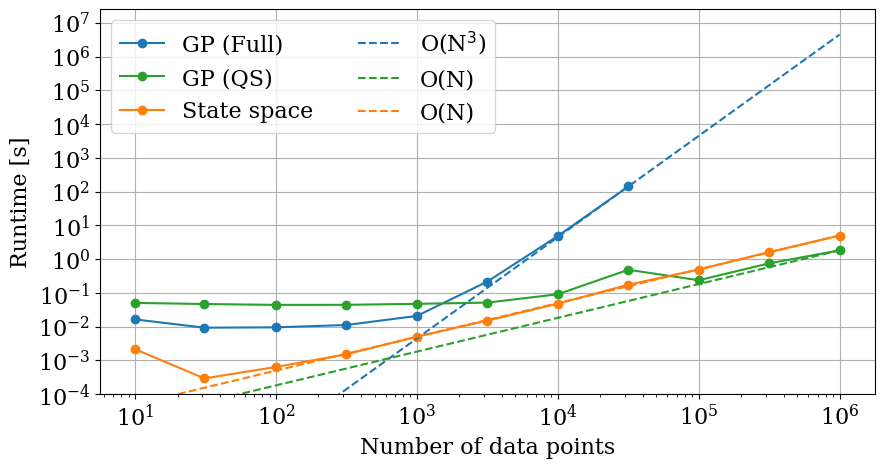

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(Ns, tgp, 'o-', color='C0', label='GP (Full)')
ax.plot(Ns, tqs, 'o-', color='C2', label='GP (QS)')
ax.plot(Ns, tss, 'o-', color='C1', label='State space')

Nss = np.logspace(1, 6, 100)
idxgp = np.where(~np.isnan(tgp))[0][-1]
ax.plot(Nss, tgp[idxgp]*(Nss/Ns[idxgp])**3, ls='--', color='C0',  label='O(N$^3$)')
ax.plot(Nss, tqs[-1]*(Nss/Ns[-1]),    ls='--', color='C02', label='O(N)')
ax.plot(Nss, tss[-1]*(Nss/Ns[-1]),    ls='--', color='C1',  label='O(N)')
ax.legend(ncol=2)

ax.set(xlabel='Number of data points', ylabel='Runtime [s]',
       xscale='log', yscale='log')
ax.set_ylim(bottom=max(ax.get_ylim()[0], 1e-4))

from matplotlib.ticker import LogLocator
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=len(Ns)))
ax.grid()
plt.savefig('/Users/rrubenzahl/Desktop/figures/ss_vs_gp_benchmark.png', dpi=300, bbox_inches='tight')

### Helper function to check we're initializing correctly

In [48]:
def check_initial_covariance(F, L, Qc, H, P0, kernel_var_expected, tol=1e-6):
    """
    Check if initial state covariance P0 and kernel variance match.

    Args:
        F, L, Qc, H: state-space model matrices
        P0: initial covariance matrix (d x d)
        kernel_var_expected: scalar kernel variance k(0,0)
        tol: tolerance for numerical check

    Prints comparison and returns True if consistent.
    """
    # Compute initial output variance implied by P0
    initial_var = (H @ P0 @ H.T).item()
    print(f"Kernel variance at t=0: {kernel_var_expected:.6g}")
    print(f"Initial covariance projected to output space: {initial_var:.6g}")

    # Check closeness
    if jnp.abs(initial_var - kernel_var_expected) > tol:
        print("WARNING: Initial covariance P0 does NOT match kernel variance within tolerance.")
        return False
    else:
        print("Initial covariance P0 matches kernel variance within tolerance.")
    return True


kernel_var = shokern(jnp.array([0.0]), jnp.array([0.0]))[0,0]
consistent = check_initial_covariance(F, L, Qc, H, P0, kernel_var)

Kernel variance at t=0: 0.351133
Initial covariance projected to output space: 0.351133
Initial covariance P0 matches kernel variance within tolerance.


# 7. Exposure-integrated observations

## 7.1 Traditional GP approach
Handling exposure-integrated observations, especially when observations are allowed to overlap, requires significant bookkeeping. In the traditional GP framework, the cross-covariance between two datapoints $t_i$ and $t_j$ with exposure times $\delta_i$ and $\delta_j$ is:
\begin{align*}
k_{F,F}(t_i,t_j,\delta_i,\delta_j) = \frac{1}{\delta_i \delta_j} \int_{t_i-\delta_i/2}^{t_i+\delta_i/2} \int_{t_j-\delta_j/2}^{t_j+\delta_j/2} k(t,t') dt dt'. \tag{7.1}
\end{align*}
As Luhn et al. (in prep) show, special care is needed to handle partially overlapping observations as the two integrals become coupled for that overlapping period. For the case of fully separated observations, as well as perfectly overlapping observations (such as an observation with itself, i.e. the diagonal), the integral yields a closed-form analytic solution. These two cases can then be combined with appropriate weighting along the non-overlapping and shared segments of partially overlapping observations to correctly recover the joint covariance for arbitrary overlap. However, the logic needed to implement this in practice prevents the use of quasiseparable linear algebra, even if the underlying kernel is stationary and quasiseparable, for the simple reason that the overlapping observations live near to the diagonal (in a time-ordered matrix) without exploitable structure (they also do not form a LEAF ([Delisle et al. 2021](https://www.aanda.org/articles/aa/full_html/2022/03/aa41949-21/aa41949-21.html)) matrix). 

Datastreams generated by a single instrument, in general, should not have any overlapping observations. It would then be possible to represent the integrated GP kernel in quasiseparable form in that case. For example, an integrated SHO kernel can be expressed as the sum of four SHO kernels at shifted times and modified amplitudes, and two constant terms, each of which is compatible with a quasiseparable form. However, combining data from multiple instruments during shared observing windows will often yield overlapping pairs of observations. In that case, the GP formalism is cursed to rely on dense matrix computations. In general though, for realistic datasets, overlapping observations represent a small fraction of the total number of datapoints (and certainly a small fraction of all the possible pairs of observations), so the dense matrix representation (while formally correct) is an overly cumbersome way to deal with this problem.

### Aside/move to "intro"

Previous works in the state space formalism have treated integrated measurements as an integrated observation model and integrated process noise over the exposure [e.g., Qian and Chang 2021](https://www.sciencedirect.com/science/article/abs/pii/S0263224121002268). While this works, it involves very gross integrals. See past version of this notebook for the math (pre 9/18/2025).

## 7.2 State space approach

$\providecommand{\pm}{}$
$\renewcommand{\pm}[1]{\begin{pmatrix}#1\end{pmatrix}}$

The state space formalism allows for a more elegant solution (which preserves the O(N) time complexity *and* is compatible with the parallel method) by integrating the dynamics, rather than the covariance.

Let $y_n$ be the exposure-averaged measurement at observation $n \in [1,N]$, 
\begin{align*}
y_n &= \frac{1}{\delta_n} \int_{t^s_n}^{t^e_n}H_n f(\tau)d\tau + \epsilon_n.   \tag{7.2}
\end{align*}
where $t^s_n$ and $t^e_n$ are the start and stop times of the exposure, with length $\delta_n = t^e_n - t^s_n$. Because integration is a linear operator, it preserves the linear, Gaussian nature of the state space system ([S&auml;rkk&auml; 2011](https://users.aalto.fi/~ssarkka/pub/spde.pdf)). Moreover, our state is generally already the joint state of the instantaneous latent state and its first $d-1$ time derivatives. We can thus introduce the integral state $z$ such that
\begin{align*}
\frac{dz}{dt} = x   \tag{7.3}
\end{align*}

Now, our state space model is for the joint state $\bm{X} = [\bm{x};\bm{z}] = [x, \dot{x}, z, \dot{z}] = [x, \dot{x}, z, x]$ which will have the following SDE:
\begin{align*}
\frac{d\bm{X}}{dt} &= \tilde{\bm{F}} \bm{X} + \tilde{\bm{L}} w,   \tag{7.4} \\
\end{align*}
where we have the augmented matrices
\begin{align*}
\tilde{\bm{F}} = \pm{\bm{F} & 0 \\ \bm{I} & 0}, \quad \tilde{\bm{L}} = \pm{\bm{L} \\ 0},  \tag{7.5}
\end{align*}

and $\bm{I}$ is the $d\times d$ identity. The corresponding augmented transition matrix is
\begin{align*}
\tilde{\bm{\Phi}}(\Delta) = \pm{\bm{\Phi}(\Delta) & 0 \\ 
                                \bar{\bm{\Phi}}(\Delta) & \bm{I}}, 
                        \quad \bar{\bm{\Phi}}(\Delta) = \int_0^\Delta \bm{\Phi}(\tau) d\tau.     \tag{7.6}
\end{align*}
We can confirm this definition gives the desired behavior:
\begin{align*}
\bm{X}(\Delta + t_0) &= \tilde{\bm{\Phi}} \bm{X}(t_0) \\
\pm{\bm{x} \\ \bm{z}}(\Delta + t_0) &= \pm{\bm{\Phi}(\Delta) & 0 \\ \bar{\bm{\Phi}}(\Delta) & \bm{I} } \pm{\bm{x} \\ \bm{z}}(t_0) \\
\pm{\bm{x}(\Delta + t_0) \\ \bm{z}(\Delta + t_0)} &= \pm{\bm{\Phi}(\Delta) x(t_0) \\ \bar{\bm{\Phi}}(\Delta) x(t_0) + z(t_0) }.    \tag{7.7}
\end{align*}

In other words, Eq. 7.7 shows the $x$ state evolves according to the instantaneous dynamics, while $z$ is accumulated over the transition. The augmented process noise is then
\begin{align*}
\tilde{\bm{Q}} &= \int_0^\Delta \tilde{\bm{\Phi}}(\tau)\tilde{\bm{L}}Q_c\tilde{\bm{L}}^T\tilde{\bm{\Phi}}(\Delta)^T d\tau \\
        &= \pm{\int_0^\Delta \Phi(\tau) L Q_c L^T \Phi(\tau)^T d\tau & \int_0^\Delta \Phi(\tau) L Q_c L^T \bar{\Phi}(\tau)^T d\tau \\
            \int_0^\Delta \bar{\Phi}(\tau) L Q_c L^T \Phi(\tau)^T d\tau  &  \int_0^\Delta \bar{\Phi}(\tau) L Q_c L^T \bar{\Phi}(\tau)^T d\tau}.
\end{align*}
    <!-- &= \pm{ \tilde{Q}_{xx}(\Delta) & \tilde{Q}_{xz}(\Delta) \\ 
            \tilde{Q}_{zx}(\Delta) & \tilde{Q}_{zz}(\Delta)} -->
Each of these four individual components has its own representation as a Van Loan matrix exponential ([Van Loan 1978](https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c)), and likewise $\tilde{Q}$ can be computed at once from $\tilde{F}$ and $\tilde{L}Q_c\tilde{L}^T$. 

We can now discretize the model at each of the exposure start ($t^s_n$) and stop ($t^e_n$) times, giving us a total of $K = 2N$ states. We define the observation model at each state to be
\begin{align*}
0 &= z(t_k) & \text{if} \; t_k = t^s_n \; \text{is a start state}, \\
y_n &= \bm{H}_k \bm{X}_k + \epsilon_k = \frac{1}{\delta_n}z(t_k) + \epsilon_k & \text{if} \; t_k = t^e_n \; \text{is a stop state}, \\ \tag{7.8}
\end{align*}
where $\epsilon_k \sim N(0,\,\bm{R})$ and $\bm{R}$ is the measurement covariance matrix as before. Since we have explicitly reset the integral state to identically zero at the start of the exposure, $z(t^e_n)$ directly gives us the integrated latent state over the exposure window. Projecting to the observed space by $H_k = \frac{1}{\delta_k}[0,0,1,0]$ gives us the exposure-averaged state.

Finally, the initial mean and covariance of this model is
\begin{align*}
\bm{m}_0 = 0,   \quad  \bm{P}_0 = \pm{P_\infty & 0 \\
                                        0 & I
                                    }.
\end{align*}

### Integrated Kalman filter 

Define the reset matrix $\bm{\mathcal{R}}$ to be
\begin{align*}
\bm{\mathcal{R}} = \pm{I & 0 \\ 0 & 0}
\end{align*}
so that the $\bm{x}$ state is preserved but the $\bm{z}$ state is zeroed-out. The Kalman filter for an exposure start state $k$ reduces to
\begin{align*}
\text{Prediction:}&  \\
m_{k}^{-} &= A_{k-1} m_{k-1},  \\
P_{k}^{-} &= A_{k-1} P_{k-1} A_{k-1}^T + Q_{k-1}.  \\
\text{Update:}&    \\
m_k &= \mathcal{R} m_{k}^{-},  \\
P_k &= \mathcal{R} P_{k}^{-} \mathcal{R}^T.  \\
\end{align*}
In other words, the predicted exposure-start state is the same as the usual Kalman prediction from the previous state. We then consider the filtered exposure-start state as a deterministic transition from that prediction, taking the reset matrix as our transition matrix. An exposure-stop state is predicted and filtered according to the usual Kalman filter prescription (Section 2). All the work to handle exposure integration is built-in to $z$ and $H_k$.

### Integrated RTS smoother

RTS smoothing for exposure-stop states have the same form as in Section 3. RTS smoothing for exposure-start states are a bit more subtle, as we have to carefully "reverse" the update/reset step of the Kalman filter. Interpreting the reset matrix as a transition matrix, we basically have a two-step smoothing over the start state from post- to pre-reset. For an exposure start state $k$, denote $k$ as the pre-reset state (has Kalman predicted result $m_k^-$, $P_k^-$) and $k^+$ the post-reset state (has Kalman filtered result $m_k$, $P_k$). Then

\begin{align*}
\text{Smooth $k+1 \rightarrow k$ (post-reset):}&  \\
G_{k^+} &= P_k A_k^T \left[ P_{k+1}^{-} \right]^{-1},  \\
\hat{m}_{k^+} &= m_k + G_{k^+} \left[ \hat{m}_{k+1} - m_{k+1}^{-} \right], \\
\hat{P}_{k^+} &= P_k + G_{k^+} \left[ \hat{P}_{k+1} - P_{k+1}^{-} \right] G_{k^+}^T.  \\

\text{Smooth $k \rightarrow k^-$ (pre-reset):}&  \\
P_{k^+}^- &= P_k + (I - \mathcal{R}) \\
G_k &= P_k^- \mathcal{R}^T \left[ P_{k^+}^- \right]^{-1},  \\
\hat{m}_k &= m_k^- + G_k \left[ \hat{m}_{k^+} - m_k \right],  \\
\hat{P}_k &= P_k^- + G_k \left[ \hat{P}_{k^+} - P_k \right] G_k^T.  \\

\end{align*}

Note that we added $I - \mathcal{R}$ to the post-reset covariance $P_k$ to make it non-singular ($P_{k^+}^-$) so its inverse can be computed. This does not affect the end result, since the next step (calculating $G_k$) is to left-multiply $\left[ P_{k^+}^- \right]^{-1}$ by $\mathcal{R}^T$ which zeroes those components out again.

### Dealing with overlapping observations

This is now a bookkeeping problem:
- still define states as all starts and ends like before, k=1,...2N
- still assign obsid n=1,..N and obsid[k] lookup so we can get the matching observation
- new: assign instid for each state so we know which instrument that observation belongs to
- new: keep track whether each state is a start or an end in separate state_id list of 0/1

We assume observations from a given instrument do not overlap, and that all overlap arises between pairs of instruments. Thus, we can introduce a $z_i$ state for each instrument into the augmented model so that our state becomes $\bm{X} = [\bm{x};\bm{z}_1; \bm{z}_2, \dots]$ (where $\dot{z}_i = x\;\forall\;i$), yielding the following generalized augmented matrices for $N_\text{inst}$ instruments:
\begin{align*}
\tilde{\bm{F}} = \begin{pmatrix} \bm{F} & 0 & \dots\\ \bm{I} & 0 & \dots \\ \vdots & \vdots & \ddots \end{pmatrix},   \quad 
        \tilde{\bm{L}} = \begin{pmatrix} \bm{L} \\ 0 \\ \vdots \end{pmatrix}, \quad
        \tilde{\bm{\Phi}}(\Delta) = \begin{pmatrix} 
                        \bm{\Phi}(\Delta) &  &   \\ 
                        \bar{\bm{\Phi}}(\Delta) & \bm{I} &    \\
                        \vdots &  & \ddots   \\
                        \end{pmatrix},    \tag{7.9}
\end{align*}

and $\bm{I}$ is the $d\times d$ identity.


The only change to the Kalman filter is to reset each $z_i$ state _only_ at the start of an exposure from that instrument. That way, $z_i$ is allowed to accumulate while other instruments collect observations, thereby accounting for all the cross-correlations during overlaps by construction. Likewise, the RTS smoother must undo the reset for _only_ that instrument. That is, for instrument $i$ and integral state index $j$,
\begin{align*}
\bm{\mathcal{R}}_i = \pm{I & 0 \\ 0 & \text{blkdiag}(I-\delta_{ij})}, 
            \quad I-\delta_{ij} = \begin{cases}
                                0 & i=j \\
                                I & i\neq j
                                \end{cases}.
\end{align*}
Lastly, the initial covariance $P_0$ is $I$ for all of the $z_i$ components:
\begin{align*}
\bm{P}_0 = \text{blkdiag}(P_\infty, I, \dots).
\end{align*}

## Augmented matrices

In [49]:
d = F.shape[0] # dimensionality of the SDE
I = jnp.eye(d)
Z = jnp.zeros((d,d))

#### Augmented matrices to define: F, L, and optionally A (can always use A(dt) = expm(F*dt))
#### Generalized augmented matrix construction
#### given number of instruments
Ninst = 2
#################
L_aug = jnp.vstack([L] + [jnp.zeros_like(L)]*Ninst)
F_aug = [[F] + [Z]*Ninst]
for inst in range(Ninst):
    F_aug.append([I] + [Z]*Ninst)
F_aug = jnp.block(F_aug)

# A_aug = lambda dt: expm(F_aug*dt)
def A_aug(dt):
    ''' Augmented transition matrix for multi-instrument model '''
    PHI    = Phi(dt)
    INTPHI = Phibar(dt)
    top = [PHI] + [Z]*Ninst
    mids = []
    for inst in range(Ninst):
        row = [INTPHI] + [Z]*Ninst
        row[1+inst] = I
        mids.append(row)
    return jnp.block([top] + mids)

def Reset_matrix(instid):
    ''' Reset matrix for instrument `instid` (0-indexed) '''
    diag = jnp.ones(d*(Ninst+1))
    diag = jax.lax.dynamic_update_slice(diag, jnp.zeros(d), (d*(1+instid),))
    return jnp.diag(diag)

## Define Q using Van-Loan expm
Q_aug = lambda dt: Q_from_VanLoan(F_aug, L_aug, Qc, dt)

In [50]:
L_aug.shape, F_aug.shape, A_aug(3).shape, Q_aug(3).shape, Reset_matrix(0).shape

((6, 1), (6, 6), (6, 6), (6, 6), (6, 6))

>Note: $\bm{\bar{\Phi}}$ can be computed through an analagous matrix exponential as $\bm{Q}$ ([Van Loan 1978](https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c)) 

In [51]:
def Phibar_from_VanLoan(F, dt):
    '''
    Van Loan method to compute Phibar = ∫0^dt exp(F s) ds

    See Van Loan (1978) "Computing Integrals Involving the Matrix Exponential"
    PDF at https://www.olemartin.no/artikler/vanloan.pdf
    https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c
    '''
    b = len(F) # block size
    Z = jnp.zeros((b,b))
    I = jnp.eye(b)
    C = jnp.block([[F, I],[Z, Z]])
    VanLoanBlock = expm(C*dt)
    G3 = VanLoanBlock[:b,b:]
    return G3

In [52]:
jnp.all(jax.vmap(lambda dt: jnp.allclose(Phibar(dt), Phibar_from_VanLoan(F, dt)))(dts))

Array(True, dtype=bool)

In [53]:
# Initial mean and covariance
# For the instantaneous state use zero mean and stationary covariance
# For the integral state use zero mean and zero covariance
init_m = jnp.block([m0] + Ninst*[jnp.zeros(m0.shape)])
init_P = jnp.diag(jnp.ones(len(F_aug))).at[:d,:d].set(Pinf)

## Kalman

In [54]:
@jax.jit
def kalman_filter_integrated(t, y, texp, 
                             obsid, instids, stateid,
                             R, H):
    '''
    obsid   -- array len(K): which observation (0,...,N-1) is being made at each state k
    instids -- array len(N): which instrument (0,...,Ninst-1) recorded observation n
    stateid -- array len(N): 0 for exposure-start, 1 for exposure-end
    '''

    K = len(t)    # number of iterations (2N)
    N = int(K/2)

    if len(H) != N:
        H = jnp.full((N, *H.shape), H)  # case of constant observation model

    def step(carry, k):
        '''
        '''

        # Unpack previous state and covariance
        m_prev, P_prev = carry

        # If k==0 we use the prior m0, Pinf and zero time-lag (dt=0)
        Delta = jax.lax.cond(k > 0,
                          lambda i: t[i] - t[i-1],
                          lambda _: 0.0,
                          k)
        n = obsid[k]        # which observation are we working on
        instid = instids[n] # which instrument this observation is from
        
        # Get transition matrix
        A_prev = A_aug(Delta)
        Q_prev = Q_aug(Delta)

        # Predict step is same for exposure or gap
        m_pred = A_prev @ m_prev
        P_pred = A_prev @ P_prev @ A_prev.T + Q_prev 

        # Update the end of the exposure
        def update_end():

            ### C_k needs to select correct z using instid
            ### We observe 1/texp * z(t_e) for the current instrument
            C_k = jnp.array([jnp.zeros(d*(1+Ninst)).at[d*(1+instid)].set(1)/texp[n]])

            y_pred = C_k @ m_pred             # predicted observation
            v_k = y[n] - y_pred               # "innovation" or "surprise" term
            S_k = C_k @ P_pred @ C_k.T + R[n] # uncertainy in predicted observation
            K_k = jnp.linalg.solve(S_k.T, (P_pred @ C_k.T).T).T # Kalman gain
            m_k = m_pred + K_k @ v_k          # conditioned state estimate
            P_k = P_pred - K_k @ S_k @ K_k.T  # conditioned covariance estimate
            return m_k, P_k, m_pred, P_pred

        # Update the start of the exposure, aka reset its z to zero
        def update_start():
            Reset = Reset_matrix(instid)
            m_k = Reset @ m_pred 
            P_k = Reset @ P_pred @ Reset.T
            return m_k, P_k, m_pred, P_pred
        
        m_k, P_k, m_pred, P_pred = jax.lax.cond(
                        stateid[k]==0,
                        lambda _: update_start(), # k=2,4,... is a t_e->t_s aka gap
                        lambda _: update_end(),   # k=1,3,... is a t_s->t_e aka exposure
                        operand=None              # note k=0 is -inf->t_s is also a 'gap' update
                    )  
        
        return (m_k, P_k), (m_k, P_k, m_pred, P_pred)
    
    # Initialize carry with prior state and covariance
    init_carry = (init_m, init_P)

    # Run the filter over all time steps, unpack, and return results
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(K))
    m_filtered, P_filtered, m_predicted, P_predicted = outputs
    return m_filtered, P_filtered, m_predicted, P_predicted

## RTS

In [55]:
@jax.jit
def rts_smoother_integrated(t, obsid, instids, stateid,
                            m_filtered,  P_filtered, 
                            m_predicted, P_predicted):
    '''
    '''
    def step(carry, k):
        '''
        '''

        # Outputs from Kalman filter, unpacked for notational consistency
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        m_pred_next = m_predicted[k+1] # has superscript minus
        P_pred_next = P_predicted[k+1] # has superscript minus

        # Unpack state and covariance from last iteration
        m_hat_next, P_hat_next = carry

        # Time-lag between states
        Delta = t[k+1] - t[k]
        
        # Compute smoothing gain
        A_k = A_aug(Delta)

        # If transition is from te_k to ts_k (i.e., over the exposure)
        def smooth_start():
            ''' Back-propagate state during an exposure '''

            ## What we're working with:
            # pre-reset  at k+1: m_pred_next, P_pred_next (predicted)
            # post-reset at k+1: m_hat_next, P_hat_next (smoothed)
            # post-reset at k  : m_k, P_k (filtered)

            ## 1. t_e to post-reset t_s
            ##    aka t_k+1 to t_k+2/3
            ##    it is the RTS equations over the exposure interval
            G_k_post = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T
            m_hat_k_post = m_k + G_k_post @ (m_hat_next - m_pred_next)
            P_hat_k_post = P_k + G_k_post @ (P_hat_next - P_pred_next) @ G_k_post.T

            ## 2. post-reset t_s to pre-reset t_s
            ##    aka t_k+2/3 to t_k+1/3
            ##    it is RTS but with 'Reset' as our 'transition matrix'
            m_k_pre = m_predicted[k]  # pre-reset start state
            P_k_pre = P_predicted[k]  # pre-reset start covariance
            # After undoing the reset, add a nonzero value to the diagonal at the zeroed-out z
            # This let's us calculate the inverse, but does not affect the end result
            # since we immedietely multiply by Reset.T which deletes those rows/cols again
            Reset = Reset_matrix(instids[obsid[k]])
            # P_pred_post = Reset @ P_k_pre @ Reset.T + (jnp.eye(len(Reset))-Reset)  #### This changed
            P_pred_post = P_k + (jnp.eye(len(Reset))-Reset)  #### This changed
            G_k_pre = jnp.linalg.solve(P_pred_post.T, (P_k_pre @ Reset.T).T).T 

            ## Final smoothed state at k
            m_hat_k = m_k_pre + G_k_pre @ (m_hat_k_post - m_k)
            P_hat_k = P_k_pre + G_k_pre @ (P_hat_k_post - P_k) @ G_k_pre.T

            return m_hat_k, P_hat_k

        # If transition is from ts_k+1 to te_k (i.e., over the gap)
        def smooth_end():
            ''' Back-propagate state between exposures '''

            ## 3. pre-reset t_s to previous t_e
            ##    aka t_k+1/3 to t_k
            ##    this is simply the normal RTS update equations
            G_k = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T
            m_hat_k = m_k + G_k @ (m_hat_next - m_pred_next)
            P_hat_k = P_k + G_k @ (P_hat_next - P_pred_next) @ G_k.T

            return m_hat_k, P_hat_k

        m_hat_k, P_hat_k = jax.lax.cond(
                    stateid[k]==0,
                    lambda _: smooth_start(), 
                    lambda _: smooth_end(),   
                    operand=None
                )
        
        return (m_hat_k, P_hat_k), (m_hat_k, P_hat_k)

    # Start smoothing from final filtered state
    init_carry = (m_filtered[-1], P_filtered[-1])

    # Run backward from N-2 down to 0
    K = len(t) # number of iterations
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(K-2, -1, -1))
    m_smooth_reversed, P_smooth_reversed = outputs

    # Reverse outputs to match time order
    m_smooth = jnp.vstack([m_smooth_reversed[::-1], m_filtered[-1][None, :]])
    P_smooth = jnp.vstack([P_smooth_reversed[::-1], P_filtered[-1][None, :, :]])
    return m_smooth, P_smooth

### New predict at times to use the augmented matrices

In [56]:
@jax.jit
def predict_at_times_integrated(m_smooth, P_smooth, 
                                m_filtered, P_filtered,
                                m_predicted, P_predicted,
                                t_obs, t_test, Htest=None):    
            
    N = len(t_obs)
    Ntest = len(t_test)

    if Htest is None:
        # TODO: if this needs to be different for test
        # points it needs to be user specified somehow
        Htest = jnp.full((Ntest, *H.shape), H)

    # Nearest (future) datapoint
    k_nexts = jnp.searchsorted(t_obs, t_test, side='right')

    # Method to use for test point
    past   = (k_nexts<=0)    # Retrodict
    future = (k_nexts>=N)    # Extrapolate
    during = ~past & ~future # Interpolate
    cases = (past.astype(int)*0 + during.astype(int)*1 + future.astype(int)*2)

    def predict(k, ktest):
        '''
        Kalman prediction from most recent 
        filtered (but not RTS smoothed) state
        '''
        dt = t_test[ktest] - t_obs[k]
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        A_star = A_aug(dt) # transition matrix from t_k to t_star        ##### this changed
        Q_star = Q_aug(dt) # process noise from t_k to t_star            ##### this changed
        m_star_pred = A_star @ m_k
        P_star_pred = A_star @ P_k @ A_star.T + Q_star
        return m_star_pred, P_star_pred
    
    def smooth(k_next, ktest, m_star_pred, P_star_pred, retro=False): ##### this changed
        '''
        RTS smooth the prediction (ktest) using 
        the nearest future data point (k_next)

        m_star_pred and P_star_pred are the output of predict(k, k_star)
        '''
        # Next (future) data point predicted & smoothed state
        m_pred_next = m_predicted[k_next] # prediction (no kalman update) at next data point
        P_pred_next = P_predicted[k_next] # prediction (no kalman update) at next data point
        m_hat_next = m_smooth[k_next]     # RTS smoothed state at next data point
        P_hat_next = P_smooth[k_next]     # RTS smoothed covariance at next data point
        
        # Transition matrix
        dt = t_obs[k_next] - t_test[ktest]
        A_k = A_aug(dt)                                               ##### this changed

        # RTS update
        G_k = jnp.linalg.solve(P_pred_next.T, (P_star_pred @ A_k.T).T).T
        m_star_hat = m_star_pred + G_k @ (m_hat_next - m_pred_next)
        P_star_hat = P_star_pred + G_k @ (P_hat_next - P_pred_next) @ G_k.T
        
        return m_star_hat, P_star_hat

    def project(ktest, m_star, P_star):
        ''' Project the state vector to the observation space '''
        # TODO: if user specifies exposure time here, need to:
        ## 1. predict to start state & set z to zero
        ## 2. predict to the end state, then project using H and texp_test
        Hk = Htest[ktest]
        Ck = jnp.hstack([Hk, jnp.array([jnp.repeat(jnp.zeros_like(Hk), Ninst)])])    ##### this changed

        pred_mean = (Ck @ m_star.T).squeeze()
        pred_var  = (Ck @ P_star @ Ck.T).squeeze()
        return pred_mean, pred_var

    def retrodict(ktest):
        ''' Reverse-extrapolate from first datapoint t_star '''
        m_star, P_star = smooth(0, ktest, init_m, init_P, retro=True)
        return project(ktest, m_star, P_star)

    def interpolate(ktest):
        ''' Interpolate between nearest data points '''
        
        # Get nearest data point before and after the test point
        k_next = k_nexts[ktest]
        k_prev = k_next - 1

        # 1. Kalman predict from most recent data point (in past)
        m_star_pred, P_star_pred = predict(k_prev, ktest)

        # 2. RTS smooth from next nearest data point (in future)
        m_star_hat, P_star_hat = smooth(k_next, ktest, m_star_pred, P_star_pred)

        return project(ktest, m_star_hat, P_star_hat)

    def extrapolate(ktest):
        ''' Kalman predict from from last datapoint t_star '''
        m_star, P_star = predict(-1, ktest)
        return project(ktest, m_star, P_star)
    
    # Calculate predictions
    ktests = jnp.arange(0, Ntest, 1)
    branches = (retrodict, interpolate, extrapolate)
    (pred_mean, pred_var) = jax.vmap(lambda ktest: jax.lax.switch(cases[ktest], branches, (ktest)))(ktests)

    return pred_mean, pred_var

## New simulated dataset for testing the integrated verison

In [57]:
def make_exposure(tmid, texp_sec):
    t_in_exp = jnp.linspace(tmid-(texp_sec/60)/2, tmid+(texp_sec/60)/2, 100)
    return jnp.mean(f(t_in_exp))

In [58]:
#### Simulated dataset
np.random.seed(231)
if Ninst==1:
    yerr = 0.3 # m/s
    texp = 180 # sec
    N=10; times = jnp.linspace(t.value.min()+texp/60, t.value.max()-texp/60, N)  # uniformly sample N points
    texp_train = jnp.full(N, texp)  # constant exposure time for all observations
    yerr_train = jnp.full(N, yerr)  # constant uncertainty for all observations
    instids = jnp.zeros(N, dtype=int)
elif Ninst==2:
    ### TWO INSTRUMENTS
    texp1 =  60; texp2 = 180 # sec
    yerr1 = 0.3; yerr2 = 0.3 # m/s
    N1=30; N2=10
    times1 = jnp.linspace(t.value.min()+texp1/60, t.value.max()-texp1/60, N1)  # uniformly sample N points
    times2 = jnp.linspace(t.value.min()+texp2/60, t.value.max()-texp2/60, N2)  # uniformly sample N points
    times   = jnp.hstack([times1, times2])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int)]) # which instrument recorded each obs
    texp_train = jnp.hstack([jnp.full(N1, texp1), jnp.full(N2, texp2)]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2)]) # uncertainty for each obs
    sortidx = jnp.argsort(times)
    times      = times[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]
else:
    raise NotImplementedError("Only Ninst=1 or 2 simulated datasets implemented")

###### Generate synthetic measurements
tobs = u.Quantity(times, t.unit)
y_inst = f(tobs.value)
y_true = jnp.array([make_exposure(tobs.value[n], texp_train[n]) for n in range(len(tobs))])
t_train = tobs.to(kernel.tunit).value # times in unit of the kernel (for computing Delta) 
y_train = y_true + yerr * jax.random.normal(key, shape=(len(t_train),))
N = len(t_train)
R = jnp.square(yerr_train)

In [59]:
t_test = jnp.linspace(t_sec.min(), t_sec.max(), 1000)

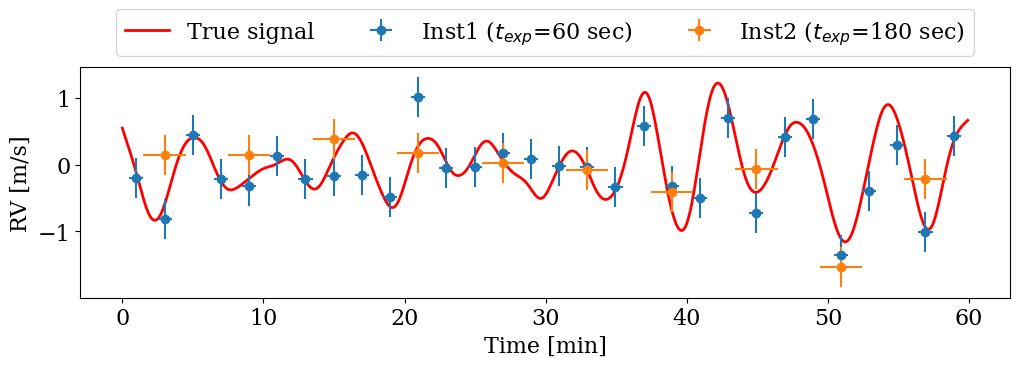

In [60]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# ax.errorbar(tobs.value, y_train, xerr=texp/60/2, yerr=yerr, fmt='o', color='k', label=r'$t_{exp}$=' + f'{texp} sec')
for instid in range(Ninst):
    inst = (instids==instid)
    ax.errorbar(tobs.value[inst], y_train[inst], xerr=texp_train[inst]/60/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')

ax.legend(ncol=3, bbox_to_anchor=[0.5,1], loc='lower center')
ax.set(ylabel='RV [m/s]', xlabel=f'Time [{t.unit}]');

In [61]:
tmid = t_train # exposure midpoints

## Construct interleaved time array for integrated Kalman/RTS
ts = tmid - texp_train/2  # Exposure start times
te = tmid + texp_train/2  # Exposure end times
obsid = jnp.arange(len(tmid)).repeat(2)  # which observation does each time belong to

# Interleave start and end times into one array (fastest)
# https://stackoverflow.com/questions/5347065/interleaving-two-numpy-arrays-efficiently
t_states = np.empty((ts.size + te.size,), dtype=tmid.dtype)
t_states[0::2] = ts  # evens are start times
t_states[1::2] = te  # odds are end times
# Have to re-sort because exposures can overlap
sortidx  = jnp.argsort(t_states)
t_states = t_states[sortidx]
obsid    = obsid[sortidx] 
stateids = jnp.tile(jnp.array([0,1]), len(tmid))[sortidx] # 0 for t_s, 1 for t_e

In [62]:
print('k   t[s]    obs  inst  state')
print('----------------------------')
for k in range(len(t_states)):
    print(f'{k:<2d}  {t_states[k]:<7.1f}  {obsid[k]:<2}   {instids[obsid[k]]}   {stateids[k]}')
    if k>8:
        break

k   t[s]    obs  inst  state
----------------------------
0   30.0     0    0   0
1   90.0     0    0   1
2   90.0     2    1   0
3   149.8    1    0   0
4   209.8    1    0   1
5   269.7    3    0   0
6   270.0    2    1   1
7   329.7    3    0   1
8   389.5    4    0   0
9   449.4    6    1   0


## Run integrated solver

In [63]:
# Kalman filters
kalman_results = kalman_filter_integrated(t_states, y_train, texp_train, 
                                          obsid, instids, stateids, 
                                          R, H)
                                          
m_filtered_int, P_filtered_int, m_predicted_int, P_predicted_int = kalman_results

# RTS smoother
m_smooth_int, P_smooth_int = rts_smoother_integrated(t_states, obsid, instids, stateids,
                                                     m_filtered_int,  P_filtered_int, 
                                                     m_predicted_int, P_predicted_int)

In [64]:
k = 0
print(f'(k={k}) |', ['Start of obs', 'End of obs'][stateids[k]], obsid[k], f'(Inst: {instids[obsid[k]]})')
print('State:    ', "[x x'" + ''.join([f" z{i} z{i}" for i in range(Ninst)]) + ']')
print('----------------------------')
print('Predicted:', m_predicted_int[k])
print('Filtered: ', m_filtered_int[k])
print('Smoothed: ', m_smooth_int[k])

(k=0) | Start of obs 0 (Inst: 0)
State:     [x x' z0 z0 z1 z1]
----------------------------
Predicted: [0. 0. 0. 0. 0. 0.]
Filtered:  [0. 0. 0. 0. 0. 0.]
Smoothed:  [ 1.59685793e-01 -6.47741666e-03  0.00000000e+00  0.00000000e+00
 -1.65120116e-16  4.40591571e-17]


In [65]:
print('Predicted:\n', P_predicted_int[k])
print('Filtered:\n', P_filtered_int[k])
print('Smoothed:\n', P_smooth_int[k])

Predicted:
 [[3.51132600e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33518171e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Filtered:
 [[3.51132600e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33518171e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000000

In [66]:
# Project predictive mean/var to observation space
H_n = lambda n: H / texp_train[n]  ## observation model at exposure n

## Augmented observation model
# C_k = lambda k: jnp.hstack([jnp.zeros_like(H_n(obsid[k])), H_n(obsid[k])]) # for integral state
# C_k = lambda k: jnp.hstack([H, jnp.zeros_like(H)]) # for instantaneous state    
def C_k(k):
    n = obsid[k]
    # H_k = H_n(n)
    Ck = jax.lax.dynamic_update_slice(jnp.zeros(d*(1+Ninst)), jnp.array([1.,0.])/texp_train[n], (d*(1+instids[n]),))
    return jnp.array([Ck])
C_k = jax.vmap(C_k)(jnp.arange(len(t_states)))

In [67]:
# y_ss = jnp.array([H_k[k] @ m_smooth_int[k].T for k in range(N)]).squeeze()
# yvar_ss = jnp.array([H_k[k] @ P_smooth_int[k] @ H_k[k].T for k in range(N)]).squeeze()

## Extract observed integral state for computing residuals
K = len(m_smooth_int)
y_ss = jnp.array([C_k[k] @ m_smooth_int[k].T for k in range(K)]).squeeze()
yvar_ss = jnp.array([C_k[k] @ P_smooth_int[k] @ C_k[k].T for k in range(K)]).squeeze()

# extract the end-states and put into original order (i.e. that matches t_train)
end_states = stateids==1
y_ss    = y_ss[end_states][obsid[end_states]]
yvar_ss = yvar_ss[end_states][obsid[end_states]]

In [68]:
# y_ss = (Hbar @ m_smooth_int.T).squeeze()
# yvar_ss = (Hbar @ P_smooth_int @ Hbar.T).squeeze()
yerr_ss = jnp.sqrt(yvar_ss)

In [69]:
# Predict at test times using both the instantaneous start/end smoothed states
mu_ss, var_ss = predict_at_times_integrated(m_smooth_int,    P_smooth_int, 
                                            m_filtered_int,  P_filtered_int,
                                            m_predicted_int, P_predicted_int,
                                            t_states, t_test, 
                                            Htest=None)
std_ss = jnp.sqrt(var_ss)

In [70]:
np.all(np.isfinite(m_predicted_int)),\
np.all(np.isfinite(m_filtered_int)),\
np.all(np.isfinite(m_smooth_int))

(np.True_, np.True_, np.True_)

In [71]:
np.all(np.isfinite(P_predicted_int)),
np.all(np.isfinite(P_filtered_int)),
np.all(np.isfinite(P_smooth_int))

np.True_

In [72]:
np.all(np.isfinite(mu_ss)), np.all(np.isfinite(std_ss))

(np.True_, np.True_)

### GP version for comparison

In [73]:
diag = yerr**2 

# Exposure start, mid, endtimes
texps = u.Quantity(texp_train, 's')
tstart, tend = (tobs - texps/2).to('s').value, (tobs + texps/2).to('s').value

### integrated prediction at data points 
zeros = jnp.zeros_like(t_train) # for instid
texp_pred = u.Quantity(texp_train, 's') # use exposure time
tup = (tobs, jnp.zeros_like(tobs), texp_pred)
### instantaneous prediction on test grid
ts = u.Quantity(t_test, 's').to('min')
zeros = jnp.zeros_like(t_test) # for instid
zeroexp = u.Quantity(jnp.zeros_like(t_test), 's') # for instantaneous curve
tups = (ts, zeros, zeroexp)
### Full GP predictions
sho_intkern = gpkernels.IntegratedOscillationKernel()
gp = tinygp.GaussianProcess(sho_intkern, tup, diag=diag)
y_gp, yvar_gp = gp.predict(y_train, tup,  return_var=True)
mu_gp, var_gp = gp.predict(y_train, tups, return_var=True)
yerr_gp = jnp.sqrt(yvar_gp)
std_gp  = jnp.sqrt(var_gp)

Defaulting to solar values.


## Comparison plot

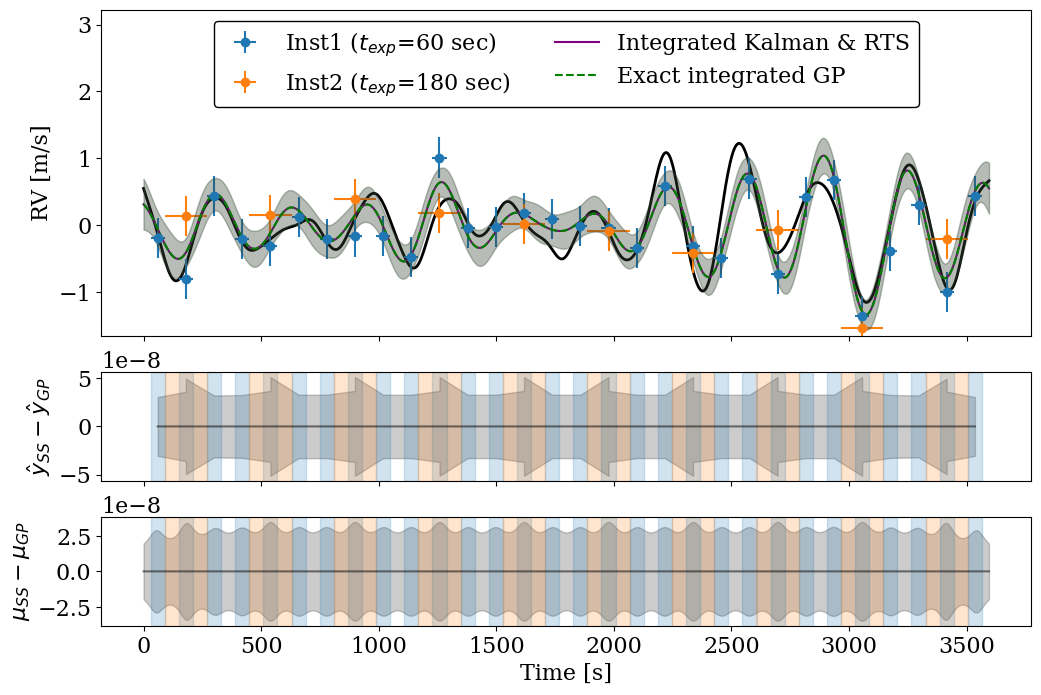

In [74]:
fig, (ax, rax, rrax) = plt.subplots(3,1, figsize=(12, 8), sharex=True, 
                                    gridspec_kw={'height_ratios':[3,1,1]})

css = 'purple'

lines = []
l1, = ax.plot(t.to(kernel.tunit).value, f(t), label='True signal', color='k', lw=2)
# lines.append(l1)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# l2 = ax.errorbar(t_train, y_train, xerr=texp_train/2, yerr=yerr, fmt='o', 
#                  color='k', label=r'$t_{exp}$=' + f'{texp} sec')
# lines.append(l2)
for instid in range(Ninst):
    inst = (instids==instid)
    l2 = ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')
    lines.append(l2)

## State space version
# _, = ax.plot(t_train, y_ss, 'o',  color=css,  ls='-', zorder=2)
# ax.fill_between(t_train, y_ss-yerr_ss, y_ss+yerr_ss, zorder=2, color=css, alpha=0.2)
l3, = ax.plot(t_test, mu_ss, color=css, label="Integrated Kalman & RTS", ls='-')
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=2, color=css, alpha=0.2)

## Full GP version
# _, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='--',)
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)
l4, = ax.plot(t_test, mu_gp, color=cgp,   ls='--', label="Exact integrated GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, zorder=2, color=cgp, alpha=0.2)

# rax.plot(t_train, y_ss - y_true, color=css, ls='-')
# rax.plot(t_train, y_gp - y_true, color=cgp, ls='--')
# rax.fill_between(t_train, y_ss-yerr_ss - y_true, y_ss+yerr_ss - y_true, ls='-',  color=css, alpha=0.2)
# rax.fill_between(t_train, y_gp-yerr_gp - y_true, y_gp+yerr_gp - y_true, ls='--', color=cgp, alpha=0.2)
rax.plot(t_train, y_ss - y_gp, ls='-', color='k', alpha=0.5)
rax.fill_between(t_train, (y_ss-yerr_ss) - (y_gp-yerr_gp), (y_ss+yerr_ss) - (y_gp+yerr_gp), ls='-', color='k', alpha=0.2)
for n, (t1, t2) in enumerate(zip(tstart, tend)):
    rax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rax.set(ylabel=r'$\hat{y}_{SS}- \hat{y}_{GP}$')

mu_true = f(u.Quantity(t_test/60, 'min'))
# rrax.plot(t_test, mu_gp - mu_true, ls='-', color=cgp, alpha=1)
# rrax.fill_between(t_test, mu_gp-std_gp - mu_true, mu_gp+std_gp - mu_true, ls='-', color=cgp, alpha=0.2)
# rrax.plot(t_test, mu_ss - mu_true, ls='-', color=css, alpha=0.5)
# rrax.fill_between(t_test, mu_ss-std_ss - mu_true, mu_ss+std_ss - mu_true, ls='-', color=css, alpha=0.2)
# rrax.set(ylabel=r'$\mu - \mu_{true}$')

rrax.plot(t_test, mu_ss - mu_gp, ls='-', color='k', alpha=0.5)
rrax.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), (mu_ss+std_ss) - (mu_gp+std_gp), ls='-', color='k', alpha=0.2)
for n, (t1, t2) in enumerate(zip(tstart, tend)):
    rrax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rrax.set(ylabel=r'$\mu_{SS}- \mu_{GP}$')

lines.extend([l3, l4])
ax.legend(lines, [l.get_label() for l in lines],
            ncol=2, loc='upper center', framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
ax.set_ylim(f(t).min()-.5, f(t).max()+2)
ax.set(ylabel='RV [m/s]');
# rax.set(ylabel=r'$\hat{y}-\hat{y}_\mathrm{true}$')
rrax.set(xlabel=f'Time [{kernel.tunit}]');
plt.savefig('/Users/rrubenzahl/Desktop/figures/ss_vs_gp_integrated.png', dpi=300, bbox_inches='tight')

In [75]:
in_exposure = jnp.zeros_like(t_test, dtype=bool)
for t1, t2 in zip(t_states[0::2], t_states[1::2]):
    in_exposure = in_exposure | ((t_test >= t1) & (t_test <= t2))

In [76]:
np.mean(mu_gp[~in_exposure] - mu_ss[~in_exposure])

Array(1.35276008e-14, dtype=float64)

In [77]:
mu_gp[-1]-mu_ss[-1]

Array(1.55431223e-15, dtype=float64)

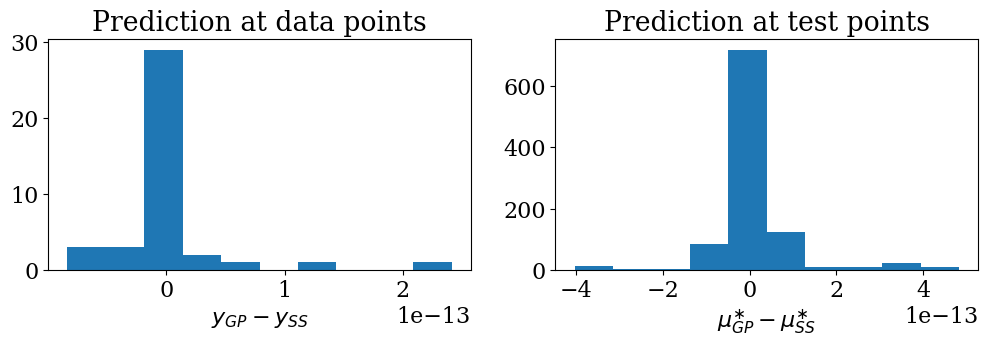

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$');

maxerr = jnp.nanpercentile(jnp.abs(mu_gp-mu_ss), 99)
ax2.hist(mu_gp - mu_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# 8. Constructing a kernel from component kernels

## 8.1 Sum of kernels

In the GP framework, a sum of covariance kernels yields another covariance kernel
\begin{align}
\bm{K} = \bm{K}_1 + \bm{K}_2 + ... + \bm{K}_M = \sum_{m=0}^{M} \bm{K}_m \nonumber
\end{align}

In the SDE representation, sums of stationary covariance functions can be constructed by stacking the model in a block-diagonal representation ([Algorithm 12.9 (pdf page 273) in S&auml;rkk&auml; and Solin 2019](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf)):

\begin{align}
\bm{F} &= \text{blkdiag}(\bm{F}_1, \bm{F}_2, ...),      &       \bm{L}   &= \text{blkdiag}(\bm{L}_1, \bm{L}_2, ...), \nonumber \\
\bm{Q} &= \text{blkdiag}(\bm{Q}_1, \bm{Q}_2, ...),      &       \bm{P}_\infty &= \text{blkdiag}(\bm{P}_{\infty,1}, \bm{P}_{\infty,2}, ...), \nonumber
\end{align}

The matrix exponential $\Phi(\Delta) = \exp(F \Delta)$ is also simply the block diagonal matrix of component matrix exponentials, per the definition of the matrix exponential:
\begin{align*}
\bm{\Phi}(\Delta) &= \exp(\bm{F}\Delta) \\
                  &= \exp(\text{blkdiag}(\bm{F}_1, \bm{F}_2, ...) \Delta) \\
                  &= \text{blkdiag}(\bm{F}_1\Delta, \bm{F}_2\Delta, ...) \\
                  &= \text{blkdiag}(\bm{\Phi}_1, \bm{\Phi}_2, ...)(\Delta)
\end{align*}

The rest of the machinery (Kalman/RTS) proceeds as before. Each component is therefore treated as independent dynamics in the state propagation, and become coupled by the measurement model $\bm{H} = (\bm{H1} \;\bm{H2}\; ...)$. 

## 8.2 Product of kernels

[Algorithm 12.10 (pdf page 273) in S&auml;rkk&auml; and Solin 2019](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf) gives the machinery for constructing a kernel from the product of component kernels:
\begin{align*}
\bm{F} = \bm{F}_1 \otimes \bm{I} + \bm{F}_2 \otimes \bm{I} ...,      
\end{align*}

\begin{align*}
\bm{L} &= \bm{L}_1 \otimes \bm{L}_2 ..., & \bm{P}_\infty &= \bm{P}_{\infty,1} \otimes \bm{P}_{\infty,2} ... \\
\bm{Q} &= \bm{Q}_1 \otimes \bm{Q}_2 ..., & \bm{H} &= \bm{H} \otimes \bm{H} ...
\end{align*}
where $\otimes$ is the Kronecker product (which also yields block matrices). In this case, the matrix exponential $\Phi(\Delta) = \exp(F \Delta)$ becomes the Kronecker product of the two matrix exponentials 
\begin{align*}
\bm{\Phi}(\Delta) &= \exp(\bm{F}\Delta) \\
                  &= \exp(\bm{F}_1 \Delta \otimes \bm{I} + \bm{F}_2 \Delta \otimes \bm{I} ...) \\
                  &= \bm{\Phi}_1(\Delta) \otimes \bm{\Phi}_2(\Delta) ...
\end{align*}

The rest of the machinery (Kalman/RTS) proceeds as before, and the final result in the observed space again uses the coupled measurement model $\bm{H} = (\bm{H1} \;\bm{H2}\; ...)$. 

In [392]:
# tinygp does this by defining a `Block` object as a type of quasisep solver 
#   that overwrites the various matrix operations (__mul__, to_dense, transpose, etc.) 
#   those are then what the quasisep solver uses when doing the matrix algebra.
# Then defines a Sum(Quasisep) object of the same form as the actual Quasisep objects
#   but where each component matrix is a Block of the two components. 
#   Then, the Quasisep object has __add__ overwritten to use this Sum(self, other)

In [393]:
class Sum(Quasisep):
    """A helper to represent the sum of two quasiseparable kernels"""

    kernel1: Quasisep
    kernel2: Quasisep

    def coord_to_sortable(self, X: JAXArray) -> JAXArray:
        """We assume that both kernels use the same coordinates"""
        return self.kernel1.coord_to_sortable(X)


    def design_matrix(self) -> JAXArray:
        return Block(self.kernel1.design_matrix(), self.kernel2.design_matrix())

    def stationary_covariance(self) -> JAXArray:
        return Block(
            self.kernel1.stationary_covariance(),
            self.kernel2.stationary_covariance(),
        )

    def observation_model(self, X: JAXArray) -> JAXArray:
        return jnp.concatenate(
            (
                self.kernel1.observation_model(X),
                self.kernel2.observation_model(X),
            )
        )

    def transition_matrix(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
        return Block(
            self.kernel1.transition_matrix(X1, X2),
            self.kernel2.transition_matrix(X1, X2),
        )


NameError: name 'Quasisep' is not defined

# 9. Kalman/RTS predictive mean/variance for a single component kernel

Say the kernel is a sum of $M$ component kernels

\begin{align}
\bm{K} = \bm{K}_1 + \bm{K}_2 + ... + \bm{K}_M = \sum_{m=0}^{M} \bm{K}_m \nonumber
\end{align}

In GP regression, we can compute the predictive mean and variance from any of the individual kernel components as

\begin{align}
\mu_{m, GP} &= \bm{K}_{m, \ast}^T (\bm{K} + \bm{N})^{-1} \bm{y}     \nonumber \\
\text{Cov}_{m, GP} &= \bm{K}_{m,\ast\ast} - \bm{K}_{m,\ast}^T (\bm{K} + \bm{N})^{-1} \bm{K}_{m,\ast}.  \nonumber
\end{align}

Basically, wherever the kernel is computed with test points, we only use the component kernel of interest. It is then true that

\begin{align}
\mu_{GP} &= \sum_{m=0}^M \mu_{m, GP}     \nonumber \\
\text{Cov}_{GP} &= \sum_{m=0}^M \text{Cov}_{m, GP}.  \nonumber
\end{align}

To do the same in the state space framework, recall that the structure of a sum/product of kernels given in Section 8 treates the dynamics of each component as independent (the matrices are combined in block diagonal form). Thus, the Kalman/RTS algorithms by construction provide us with all of the component means and variances, which get summed together when projecting through the coupled observation matrix $\bm{H} = (\bm{H1} \;\bm{H2}\; ...)$. To just pick out one component, we can simply do
\begin{align*}
\mu_{m, GP}        &= \bm{H}_m \hat{m}_m^T     \nonumber \\
\text{Cov}_{m, GP} &= \bm{H}_m \hat{P}_m \bm{H}_m^T  \nonumber
\end{align*}
where
\begin{align*}
\bm{H}_m  = (0,...,H_m,...,0) \\
\end{align*}
picks out just the observation matrix for the component of interest.